# Web page fraudulent domain detection

Phishing remains a highly successful and efficient method for cybercriminals to deceive individuals and extract their personal and financial data. 

The increasing dependence on the internet for our daily activities has created an ideal platform for cybercriminals to execute well-targeted phishing schemes.

Modern phishing attacks are intricate and harder to detect. This notebook exclusively use pyspark for analysis the url and finding it the best model for classifying them.


The dataset is use from Kaggle and direct link is https://www.kaggle.com/datasets/shashwatwork/web-page-phishing-detection-dataset

This notebook contains Exploratory Data Analysis only. The next notebook called **Pyspark ML for web page fraudulent domain detection** contains ML modeling.



In [2]:


import os  # For interacting with the operating system (e.g., file paths)
import sys  # For system-specific parameters and functions


import pyspark  # The main PySpark library for distributed data processing
from pyspark.sql.functions import * # To perform operations on DataFrame columns in pyspark
from pyspark.sql.types import * # Brings all the data types that are used to define the structure of DataFrame in pyspark
from pyspark.sql.window import Window # To perform Window functions operate on a subset of rows within a specified window
from pyspark.sql import SparkSession  # For creating a Spark session


from pyspark.ml.feature import VectorAssembler, ChiSqSelector  # For feature engineering
from pyspark.ml.classification import DecisionTreeClassifier, RandomForestClassifier, NaiveBayes, LinearSVC, GBTClassifier  # For classification algorithms
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator  # For model evaluation

from pyspark.ml import Pipeline  # For creating a pipeline
from pyspark.ml.feature import StringIndexer  # For indexing categorical target variable

import matplotlib.pyplot as plt  # For visualization 
import pandas as pd  # For data manipulation and analysis using data frames
import numpy as np  # For numerical computations and array operations
import seaborn as sns


In [3]:
# Print the versions of packages, etc.
print(f"python: {sys.version.split()[0]}")
print(f"pyspark: {pyspark.__version__}")
print(f"pandas: {pd.__version__}")


python: 3.11.4
pyspark: 3.4.1
pandas: 2.0.3


In [4]:
# Creating a Spark session
spark = SparkSession.builder.appName("URLPhishingClassifier").getOrCreate()

23/08/31 14:15:56 WARN Utils: Your hostname, MDUs-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.12 instead (on interface en0)
23/08/31 14:15:56 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/31 14:15:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
# Creating references to SparkContext and access various tasks related to distributed computing like RDD, partitions and other actions of Spark
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=URLPhishingClassifier>

In [6]:
# Reading the dataset 
data = spark.read.csv("dataset_phishing.csv", header=True, inferSchema=True) # automatically infer the data types of the columns based on the content of the CSV file


## Exploratory Data Analysis

In [7]:
# Get number of rows
num_rows = data.count()

# Get number of columns
num_columns = len(data.columns)

# Printing the result
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 11430
Number of columns: 89


- Here are 11430 rows with 89 columns

In [8]:
data.columns

['url',
 'length_url',
 'length_hostname',
 'ip',
 'nb_dots',
 'nb_hyphens',
 'nb_at',
 'nb_qm',
 'nb_and',
 'nb_or',
 'nb_eq',
 'nb_underscore',
 'nb_tilde',
 'nb_percent',
 'nb_slash',
 'nb_star',
 'nb_colon',
 'nb_comma',
 'nb_semicolumn',
 'nb_dollar',
 'nb_space',
 'nb_www',
 'nb_com',
 'nb_dslash',
 'http_in_path',
 'https_token',
 'ratio_digits_url',
 'ratio_digits_host',
 'punycode',
 'port',
 'tld_in_path',
 'tld_in_subdomain',
 'abnormal_subdomain',
 'nb_subdomains',
 'prefix_suffix',
 'random_domain',
 'shortening_service',
 'path_extension',
 'nb_redirection',
 'nb_external_redirection',
 'length_words_raw',
 'char_repeat',
 'shortest_words_raw',
 'shortest_word_host',
 'shortest_word_path',
 'longest_words_raw',
 'longest_word_host',
 'longest_word_path',
 'avg_words_raw',
 'avg_word_host',
 'avg_word_path',
 'phish_hints',
 'domain_in_brand',
 'brand_in_subdomain',
 'brand_in_path',
 'suspecious_tld',
 'statistical_report',
 'nb_hyperlinks',
 'ratio_intHyperlinks',
 'rati

### Data dictionary 

1. **url**: The URL itself.

2. **length_url**: The length of the URL.

3. **length_hostname**: The length of the hostname portion of the URL.

4. **ip**: Indicates whether the URL contains an IP address (1 for yes, 0 for no).

5. **nb_dots**: Number of dots (periods) in the URL.

6. **nb_hyphens**: Number of hyphens in the URL.

7. **nb_at**: Number of at symbols "@" in the URL.

8. **nb_qm**: Number of question marks "?" in the URL.

9. **nb_and**: Number of ampersands "&" in the URL.

10. **nb_or**: Number of vertical bars "|" in the URL.

11. **nb_eq**: Number of equal signs "=" in the URL.

12. **nb_underscore**: Number of underscores "_" in the URL.

13. **nb_tilde**: Number of tildes "~" in the URL.

14. **nb_percent**: Number of percentage signs "%" in the URL.

15. **nb_slash**: Number of forward slashes "/" in the URL.

16. **nb_star**: Number of asterisks "*" in the URL.

17. **nb_colon**: Number of colons ":" in the URL.

18. **nb_comma**: Number of commas "," in the URL.

19. **nb_semicolumn**: Number of semicolons ";" in the URL.

20. **nb_dollar**: Number of dollar signs "$" in the URL.

21. **nb_space**: Number of spaces in the URL.

22. **nb_www**: Number of "www" subdomains in the URL.

23. **nb_com**: Number of "com" subdomains in the URL.

24. **nb_dslash**: Number of double slashes "//" in the URL.

25. **http_in_path**: Indicates if "http" appears in the URL path (1 for yes, 0 for no).

26. **https_token**: Indicates if "https" is present in the URL (1 for yes, 0 for no).

27. **ratio_digits_url**: Ratio of digits in the URL length.

28. **ratio_digits_host**: Ratio of digits in the hostname length.

29. **punycode**: Indicates if Punycode encoding is used in the URL (1 for yes, 0 for no).

30. **port**: Port number in the URL.

31. **tld_in_path**: Indicates if top-level domain (TLD) is present in the URL path (1 for yes, 0 for no).

32. **tld_in_subdomain**: Indicates if TLD is present in a subdomain (1 for yes, 0 for no).

33. **abnormal_subdomain**: Indicates presence of an abnormal subdomain (1 for yes, 0 for no).

34. **nb_subdomains**: Number of subdomains in the URL.

35. **prefix_suffix**: Indicates if URL has prefix or suffix (1 for yes, 0 for no).

36. **random_domain**: Indicates if URL has a random-looking domain (1 for yes, 0 for no).

37. **shortening_service**: Indicates if a URL shortening service is used (1 for yes, 0 for no).

38. **path_extension**: Indicates presence of path extension (1 for yes, 0 for no).

39. **nb_redirection**: Number of redirections.

40. **nb_external_redirection**: Number of external redirections.

41. **length_words_raw**: Length of raw words in the URL.

42. **char_repeat**: Number of repeated characters in the URL.

43. **shortest_words_raw**: Length of shortest raw words in the URL.

44. **shortest_word_host**: Length of shortest word in the hostname.

45. **shortest_word_path**: Length of shortest word in the URL path.

46. **longest_words_raw**: Length of longest raw words in the URL.

47. **longest_word_host**: Length of longest word in the hostname.

48. **longest_word_path**: Length of longest word in the URL path.

49. **avg_words_raw**: Average length of raw words in the URL.

50. **avg_word_host**: Average length of words in the hostname.

51. **avg_word_path**: Average length of words in the URL path.

52. **phish_hints**: Presence of phishing hints (1 for yes, 0 for no).

53. **domain_in_brand**: Indicates if domain is part of a brand (1 for yes, 0 for no).

54. **brand_in_subdomain**: Indicates if brand is in a subdomain (1 for yes, 0 for no).

55. **brand_in_path**: Indicates if brand is in the URL path (1 for yes, 0 for no).

56. **suspecious_tld**: Presence of suspicious TLD (1 for yes, 0 for no).

57. **statistical_report**: Presence of a statistical report (1 for yes, 0 for no).

58. **nb_hyperlinks**: Number of hyperlinks.

59. **ratio_intHyperlinks**: Ratio of internal hyperlinks.

60. **ratio_extHyperlinks**: Ratio of external

 hyperlinks.

61. **ratio_nullHyperlinks**: Ratio of null hyperlinks.

62. **nb_extCSS**: Number of external CSS links.

63. **ratio_intRedirection**: Ratio of internal redirections.

64. **ratio_extRedirection**: Ratio of external redirections.

65. **ratio_intErrors**: Ratio of internal errors.

66. **ratio_extErrors**: Ratio of external errors.

67. **login_form**: Presence of login form (1 for yes, 0 for no).

68. **external_favicon**: Presence of an external favicon (1 for yes, 0 for no).

69. **links_in_tags**: Number of links in tags.

70. **submit_email**: Presence of email submission (1 for yes, 0 for no).

71. **ratio_intMedia**: Ratio of internal media.

72. **ratio_extMedia**: Ratio of external media.

73. **sfh**: Server Form Handler (1 for yes, 0 for no).

74. **iframe**: Presence of iframes (1 for yes, 0 for no).

75. **popup_window**: Presence of popup windows (1 for yes, 0 for no).

76. **safe_anchor**: Presence of safe anchor (1 for yes, 0 for no).

77. **onmouseover**: Presence of onmouseover events (1 for yes, 0 for no).

78. **right_clic**: Presence of right-click events (1 for yes, 0 for no).

79. **empty_title**: Presence of empty title tags (1 for yes, 0 for no).

80. **domain_in_title**: Presence of domain in title tag (1 for yes, 0 for no).

81. **domain_with_copyright**: Presence of domain with copyright (1 for yes, 0 for no).

82. **whois_registered_domain**: Presence of a registered domain in Whois (1 for yes, 0 for no).

83. **domain_registration_length**: Length of domain registration.

84. **domain_age**: Age of the domain.

85. **web_traffic**: Web traffic related information (1 for yes, 0 for no).

86. **dns_record**: DNS record presence (1 for yes, 0 for no).

87. **google_index**: Google index status (1 for yes, 0 for no).

88. **page_rank**: Page rank.

89. **status**: Target variable indicating whether the URL is 'legitimate' or 'phishing'.

Most of the columns are URL-based features that provide various characteristics of URLs. Some columns seem to contain content-based features related to website content or behavior, such as the presence of forms, media, iframes, etc. The 'status' column is the target variable that indicates whether a URL is legitimate or classified as phishing.

### Size of the data

In [65]:
# Converting to Pandas DataFrame and calculating memory usage in MB
pandas_df = data.toPandas()

memory_usage_mb = pandas_df.memory_usage(deep=True).sum() / (1024 * 1024)
print(f"Memory usage: {memory_usage_mb:.2f} MB")


Memory usage: 6.59 MB


### Checking for duplicate data

In [26]:
# Checking if any empty cell
# Show the number of rows before and after removing duplicates
print("Number of rows before removing duplicates:", data.count())
print("Number of rows after removing duplicates:", data.dropDuplicates().count())

Number of rows before removing duplicates: 11430


23/08/30 20:59:20 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=34790Kb max_used=34795Kb free=96281Kb
 bounds [0x00000001046cc000, 0x00000001068fc000, 0x000000010c6cc000]
 total_blobs=11946 nmethods=10997 adapters=861
 compilation: disabled (not enough contiguous free space left)
Number of rows after removing duplicates: 11430


There seems to be no duplicate data

In [28]:
numeric_features = [t[0] for t in data.dtypes if t[1] == 'int']
data.select(numeric_features).describe().toPandas().transpose()

0                     1                    2    3  \
summary          count                  mean               stddev  min   
length_url       11430     61.12668416447944   55.297318035005375   12   
length_hostname  11430    21.090288713910763   10.777171075983647    4   
ip               11430   0.15056867891513562  0.35764359700478854    0   
nb_dots          11430    2.4807524059492563   1.3696862349823768    1   
...                ...                   ...                  ...  ...   
domain_age       11430    4062.5437445319335   3107.7846004952294  -12   
web_traffic      11430     856756.6433070867   1995606.0217932835    0   
dns_record       11430  0.020122484689413824    0.140425409104063    0   
google_index     11430    0.5339457567804025   0.4988681779313998    0   
page_rank        11430    3.1857392825896764    2.536955409770695    0   

                        4  
summary               max  
length_url           1641  
length_hostname       214  
ip                      1  
nb_dots                24  
...                   ...  
domain_age          12874  
web_traffic      10767986  
dns_record              1  
google_index            1  
page_rank              10  

[75 rows x 5 columns]

The average url length is 61 and average page rank is 3.18

### Is the data balanced?

In [29]:
# Perform value counts for the 'status' column
status_counts = data.groupBy("status").count()
status_counts.show()

+----------+-----+
|    status|count|
+----------+-----+
|  phishing| 5715|
|legitimate| 5715|
+----------+-----+



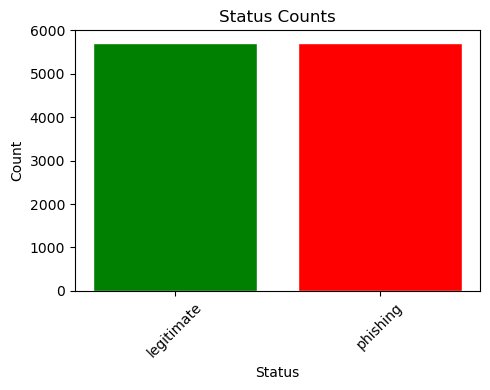

In [33]:
status_counts = data.groupBy("status").count().orderBy("status").collect()

# Extract status labels and values
status_labels = [row["status"] for row in status_counts]
status_values = [row["count"] for row in status_counts]

# Create a color list based on the status labels
color_map = {'legitimate': 'green', 'phishing': 'red'}
status_colors = [color_map[label] for label in status_labels]

# Create the bar plot
plt.figure(figsize=(5, 4))
bars = plt.bar(status_labels, status_values, edgecolor='white', color=status_colors)
plt.xlabel("Status")
plt.ylabel("Count")
plt.title("Status Counts")
plt.xticks(rotation=45)



plt.tight_layout()
plt.show()

The phishing as well as legitimate data have same records so the data is balanced and we do not have to worry about any solution related to unbalance dataset.

### What is the maximum length of domain registration?

In [53]:
# Finding the maximum domain registration length
max_length = data.agg(max("domain_registration_length")).collect()[0][0]

# Filtering the DataFrame to get the records with the maximum length
max_length_domain = data.filter(col("domain_registration_length") == max_length)

# Displaying the URLs with the maximum length in a tabular format
max_length_domain.select("url", "domain_registration_length").show(truncate=False)

+--------------------------------------+--------------------------+
|url                                   |domain_registration_length|
+--------------------------------------+--------------------------+
|http://www.eaglecounty.us/Default.aspx|29829                     |
+--------------------------------------+--------------------------+



www.eaglecountry.us is the url with longest domain registration among 11430 data.

In [36]:
# Find the maximum, minimum, and average domain registration lengths
max_length = data.agg(max("domain_registration_length")).collect()[0][0]
min_length = data.agg(min("domain_registration_length")).collect()[0][0]
avg_length = data.agg(avg("domain_registration_length")).collect()[0][0]

# Filter and order the DataFrame to get the top 3 URLs with the maximum, minimum, and average lengths
max_length_domains = data.filter(col("domain_registration_length") == max_length).orderBy(col("domain_registration_length").desc()).limit(3)
min_length_domains = data.filter(col("domain_registration_length") == min_length).orderBy(col("domain_registration_length")).limit(3)
avg_length_domains = data.filter(col("domain_registration_length") == avg_length).orderBy(col("domain_registration_length")).limit(3)

# Display the top 3 URLs for each case in a tabular format
result_df = max_length_domains.select("url", "domain_registration_length").union(
    min_length_domains.select("url", "domain_registration_length")
).union(
    avg_length_domains.select("url", "domain_registration_length")
)

result_df.show(truncate=False)

+------------------------------------------------------------------------------------------------+--------------------------+
|url                                                                                             |domain_registration_length|
+------------------------------------------------------------------------------------------------+--------------------------+
|http://www.eaglecounty.us/Default.aspx                                                          |29829                     |
|https://www.hfunderground.com/wiki/Ionosphere                                                   |-1                        |
|http://resources.infosecinstitute.com/application-security-testing-of-thick-client-applications/|-1                        |
|http://www.abm.edu.ar/                                                                          |-1                        |
+------------------------------------------------------------------------------------------------+--------------------

Among a dataset of 11,430 entries, the website 'www.eaglecountry.us' stands out with the longest domain registration, while 'www.abm.edu.ar' has the shortest domain registration.

### What is the website with the highest visitor traffic?

In [37]:
# Create a Window specification to rank URLs by web traffic in descending order
windowSpec = Window.orderBy(col("web_traffic").desc())

# Use the Window specification to get the top 3 URLs with the highest web traffic
top_traffic_domains = data.select("url", "web_traffic").withColumn("rank", dense_rank().over(windowSpec)).filter(col("rank") <= 3)

# Display the top 3 URLs with the highest web traffic in a tabular format
top_traffic_domains.show(truncate=False)

+-------------------------------------------------------------------------------------------+-----------+----+
|url                                                                                        |web_traffic|rank|
+-------------------------------------------------------------------------------------------+-----------+----+
|http://www.knowledgeonecorp.com/news/pdfs/Thin%20client%20vs%20Fat%20client%20Computing.pdf|10767986   |1   |
|http://margarita.md/slats/index.htm                                                        |10749999   |2   |
|http://chel.media/                                                                         |10745722   |3   |
+-------------------------------------------------------------------------------------------+-----------+----+



23/08/30 21:02:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/08/30 21:02:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/08/30 21:02:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/08/30 21:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
23/08/30 21:02:18 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


The website 'www.knowledgeonecorp.com' has recorded the highest traffic at 10,767,986 visits, followed closely by 'www.margarita.md' with 10,749,999 visits, and 'www.chel.media' with 10,745,722 visits

### Which domains contain their own domain names within their URLs?

In [38]:
# Count the number of URLs with domain_in_title set to 1
domain_in_title_count = data.filter(col("domain_in_title") == 1).count()

# Display the count
print("Number of URLs with domain_in_title:", domain_in_title_count)

Number of URLs with domain_in_title: 8868


Among a dataset of 11,430 entries, 8,868 urls contains their own domain names within their URLs.

### What is the distribution of the pagerank?

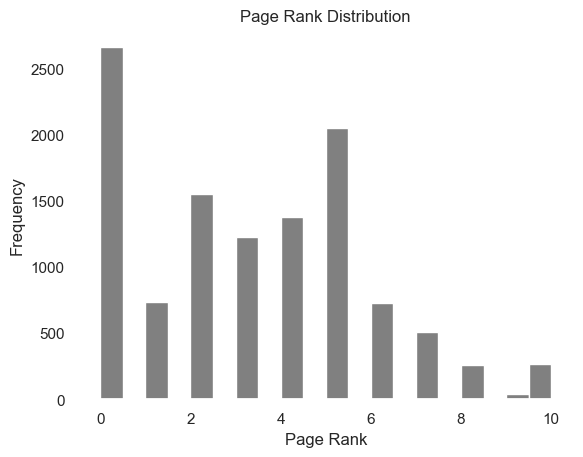

In [57]:
# Visualizing the page rank distribution

page_rank_data = data.select("page_rank").rdd.flatMap(lambda x: x).collect()

plt.hist(page_rank_data, bins=20, edgecolor='white', color='grey')
plt.xlabel("Page Rank")
plt.ylabel("Frequency")
plt.title("Page Rank Distribution")
plt.show()

### What are the three websites with the highest PageRank?

In [58]:
# Pagerank top 3 urls
top_urls_df = data.orderBy(desc("page_rank")).limit(3)

urls = top_urls_df.select("url").rdd.flatMap(lambda x: x).collect()
page_ranks = top_urls_df.select("page_rank").rdd.flatMap(lambda x: x).collect()

# Display the urls and pagerank in a tabular format
top_urls_df.select("url", "page_rank").show(truncate=False)

+---------------------------------------------------------------------------------------------------+---------+
|url                                                                                                |page_rank|
+---------------------------------------------------------------------------------------------------+---------+
|https://sites.google.com/site/ilyasdxih                                                            |10       |
|https://storage.cloud.google.com/prprhrhprc.appspot.com/index.htm#oncall-infra@eqiom.com           |10       |
|https://docs.google.com/forms/d/e/1FAIpQLSedi778KA_QpFW-6VseK02w_qghyAY4KrmhVAHDl-qBzUQytg/viewform|10       |
+---------------------------------------------------------------------------------------------------+---------+



The top three websites with the highest PageRank values are sites.google.com/site/ilyasdxih, cloud.google, and google.com/forms

/var/folders/m7/vyj4mfmx33lbl15hg59sl1mr0000gn/T/ipykernel_73517/3405444308.py:8: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


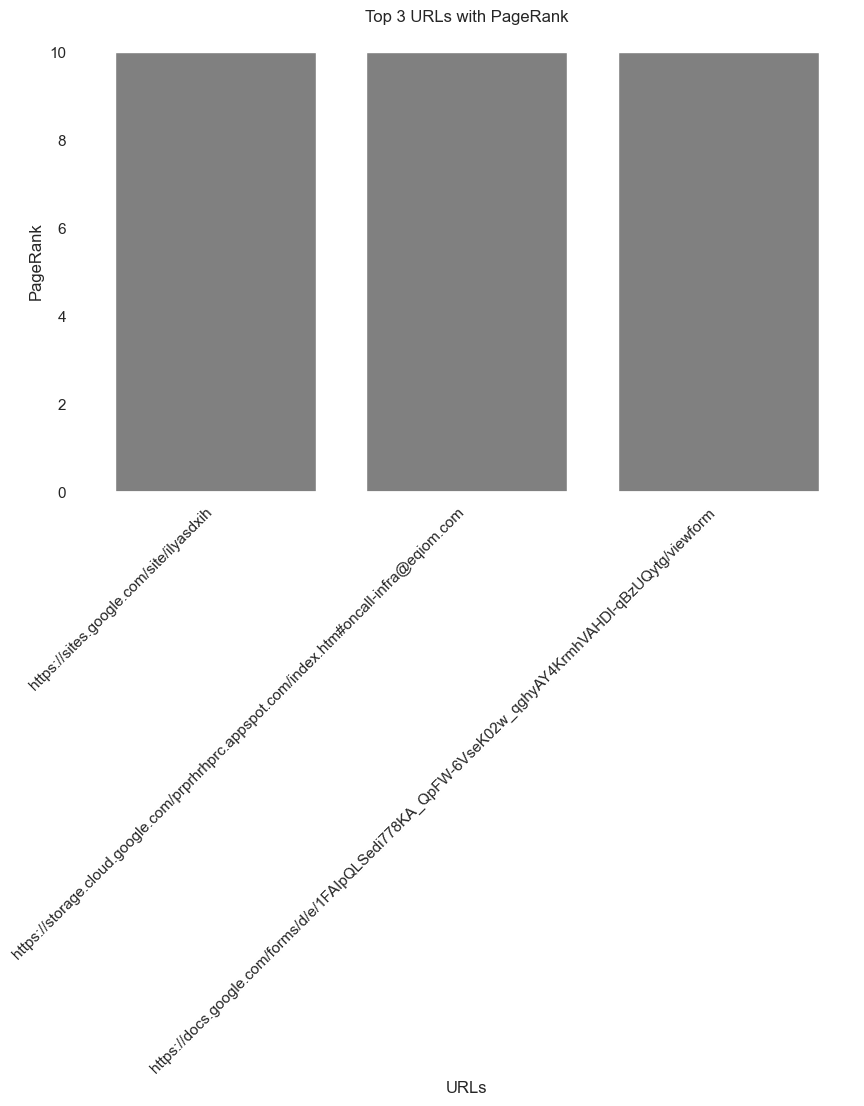

In [59]:
# Visualizing the top 3 website with pagerank
plt.figure(figsize=(10, 6))
plt.bar(urls, page_ranks, color='grey')
plt.xlabel('URLs')
plt.ylabel('PageRank')
plt.title('Top 3 URLs with PageRank')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

### What are the three websites with the lowest PageRank?

In [42]:
# Lowest pagerank website
below_top_urls_df = data.orderBy(asc("page_rank")).limit(3)

urlss = below_top_urls_df.select("url").rdd.flatMap(lambda x: x).collect()
page_rankss = below_top_urls_df.select("page_rank").rdd.flatMap(lambda x: x).collect()

# Display the urls and pagerank  in a tabular format
below_top_urls_df.select("url", "page_rank").show(truncate=False)

+--------------------------------------------------+---------+
|url                                               |page_rank|
+--------------------------------------------------+---------+
|http://beta.kenaidanceta.com/postamok/d39a2/source|0        |
|http://batvrms.net/deliver/D2017HL/u.php          |0        |
|http://www.ktplasmachinery.com/cs/                |0        |
+--------------------------------------------------+---------+



The three three websites with the lowest PageRank values are beta.kenaidanceta.com, batvrms.net and ktplasmachinery.com

### What is the length of the URL?

In [44]:
# Calculate the maximum, minimum, and rounded average length of length_url
max_length = data.agg(max("length_url")).collect()[0][0]
min_length = data.agg(min("length_url")).collect()[0][0]
avg_length = data.agg(round(avg("length_url"), 0)).collect()[0][0]

# Display the results
print("Maximum Length:", max_length)
print("Average Length:", avg_length)
print("Minimum Length:", min_length)



Maximum Length: 1641
Average Length: 61.0
Minimum Length: 12


The dataset of 11,430 entries reveals that URLs have a range of lengths, from a minimum of 12 characters to a maximum of 1,641 characters. On average, the URLs are approximately 61 characters long.


----
avg_length value is a floating-point number and not a PySpark Column object so to round the average length value, we should use the round() function provided by PySpark to round the column itself before collecting the result. 

This is the reason if you just use python normal round(), it will flag a error - like this-
```
# Calculate the maximum, minimum, and average length of length_url
max_length = data.agg(max("length_url")).collect()[0][0]
min_length = data.agg(min("length_url")).collect()[0][0]
avg_length = data.agg(avg("length_url")).collect()[0][0]

# Round the average length to two decimal places --- NOT APPLICABLE 
rounded_avg_length = round(avg_length, 2)

# Display the rounded results
print("Maximum Length:", max_length)
print("Average Length:", rounded_avg_length)
print("Minimum Length:", min_length)
```
----

### Identify legitimate and phishing-prone websites based on their traffic

/var/folders/m7/vyj4mfmx33lbl15hg59sl1mr0000gn/T/ipykernel_73517/3647936338.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[i].set_xticklabels(status_cols, rotation=45)


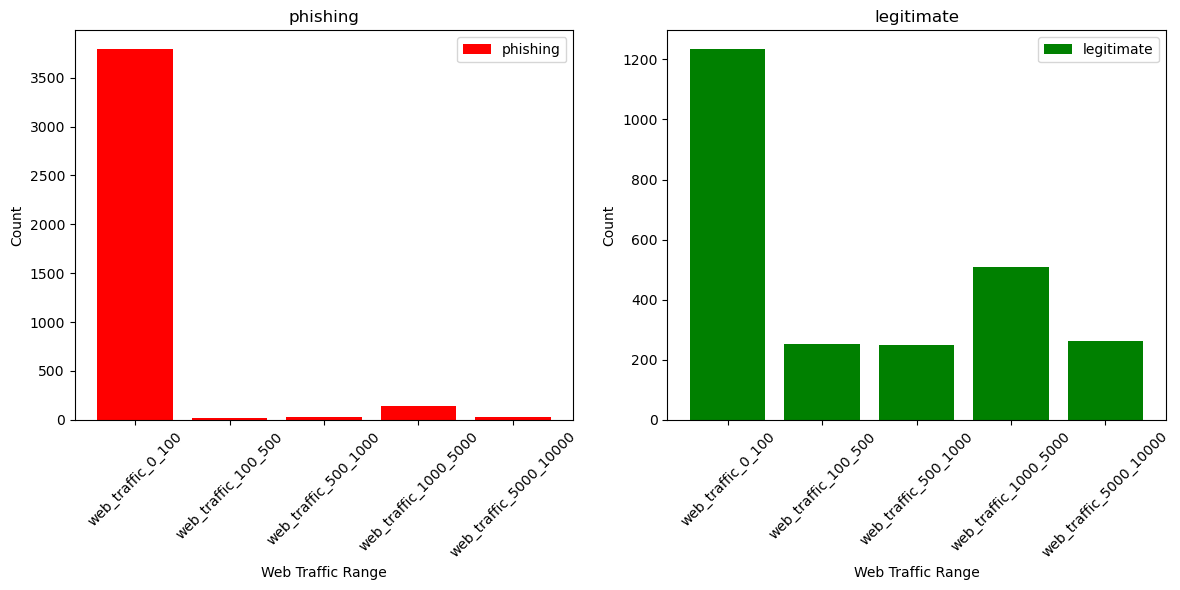

In [45]:
# Defining the web traffic ranges
web_traffic_range = [0, 100, 500, 1000, 5000, 10000]

# Creating a new column to categorize web traffic into ranges
traffic_ranges = [(web_traffic_range[i], web_traffic_range[i+1]) for i in range(len(web_traffic_range) - 1)]

for start, end in traffic_ranges:
    data = data.withColumn(
        f"web_traffic_{start}_{end}",
        when((col("web_traffic") >= start) & (col("web_traffic") < end), 1).otherwise(0)
    )

# Grouping and aggregating data for the bar plot
status_cols = [f"web_traffic_{start}_{end}" for start, end in traffic_ranges]

status_counts = data.groupBy("status").agg(*[sum(col(col_name)).alias(col_name) for col_name in status_cols]).collect()

status_labels = [row["status"] for row in status_counts]
status_values = [[row[col_name] for col_name in status_cols] for row in status_counts]

# Defining colors for statuses
status_colors = {'legitimate': 'green', 'phishing': 'red'}

# Creating two side-by-side bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for i, label in enumerate(status_labels):
    axes[i].bar(status_cols, status_values[i], color=status_colors[label], label=label)
    axes[i].set_title(label)
    axes[i].set_xlabel("Web Traffic Range")
    axes[i].set_ylabel("Count")
    axes[i].set_xticklabels(status_cols, rotation=45)
    axes[i].legend()

plt.tight_layout()
plt.show()

In [61]:

# Grouping and aggregating data for the table
table_dataa = data.groupBy("status").agg(*[sum(col(col_name)).alias(col_name) for col_name in status_cols]).collect()

# Create a pandas DataFrame from the aggregated data
table_dff = pd.DataFrame(table_dataa, columns=["status"] + status_cols)
table_dff = table_dff.set_index("status")

print(table_dff)

            web_traffic_0_100  web_traffic_100_500  web_traffic_500_1000  \
status                                                                     
phishing                 3794                   22                    25   
legitimate               1235                  251                   250   

            web_traffic_1000_5000  web_traffic_5000_10000  
status                                                     
phishing                      143                      33  
legitimate                    510                     263  


Instances with web traffic between 0 to 100 show more phishing cases (1235) compared to legitimate cases. But, instances with web traffic above 100 have more legitimate cases, suggesting a stronger legitimate presence in that range.

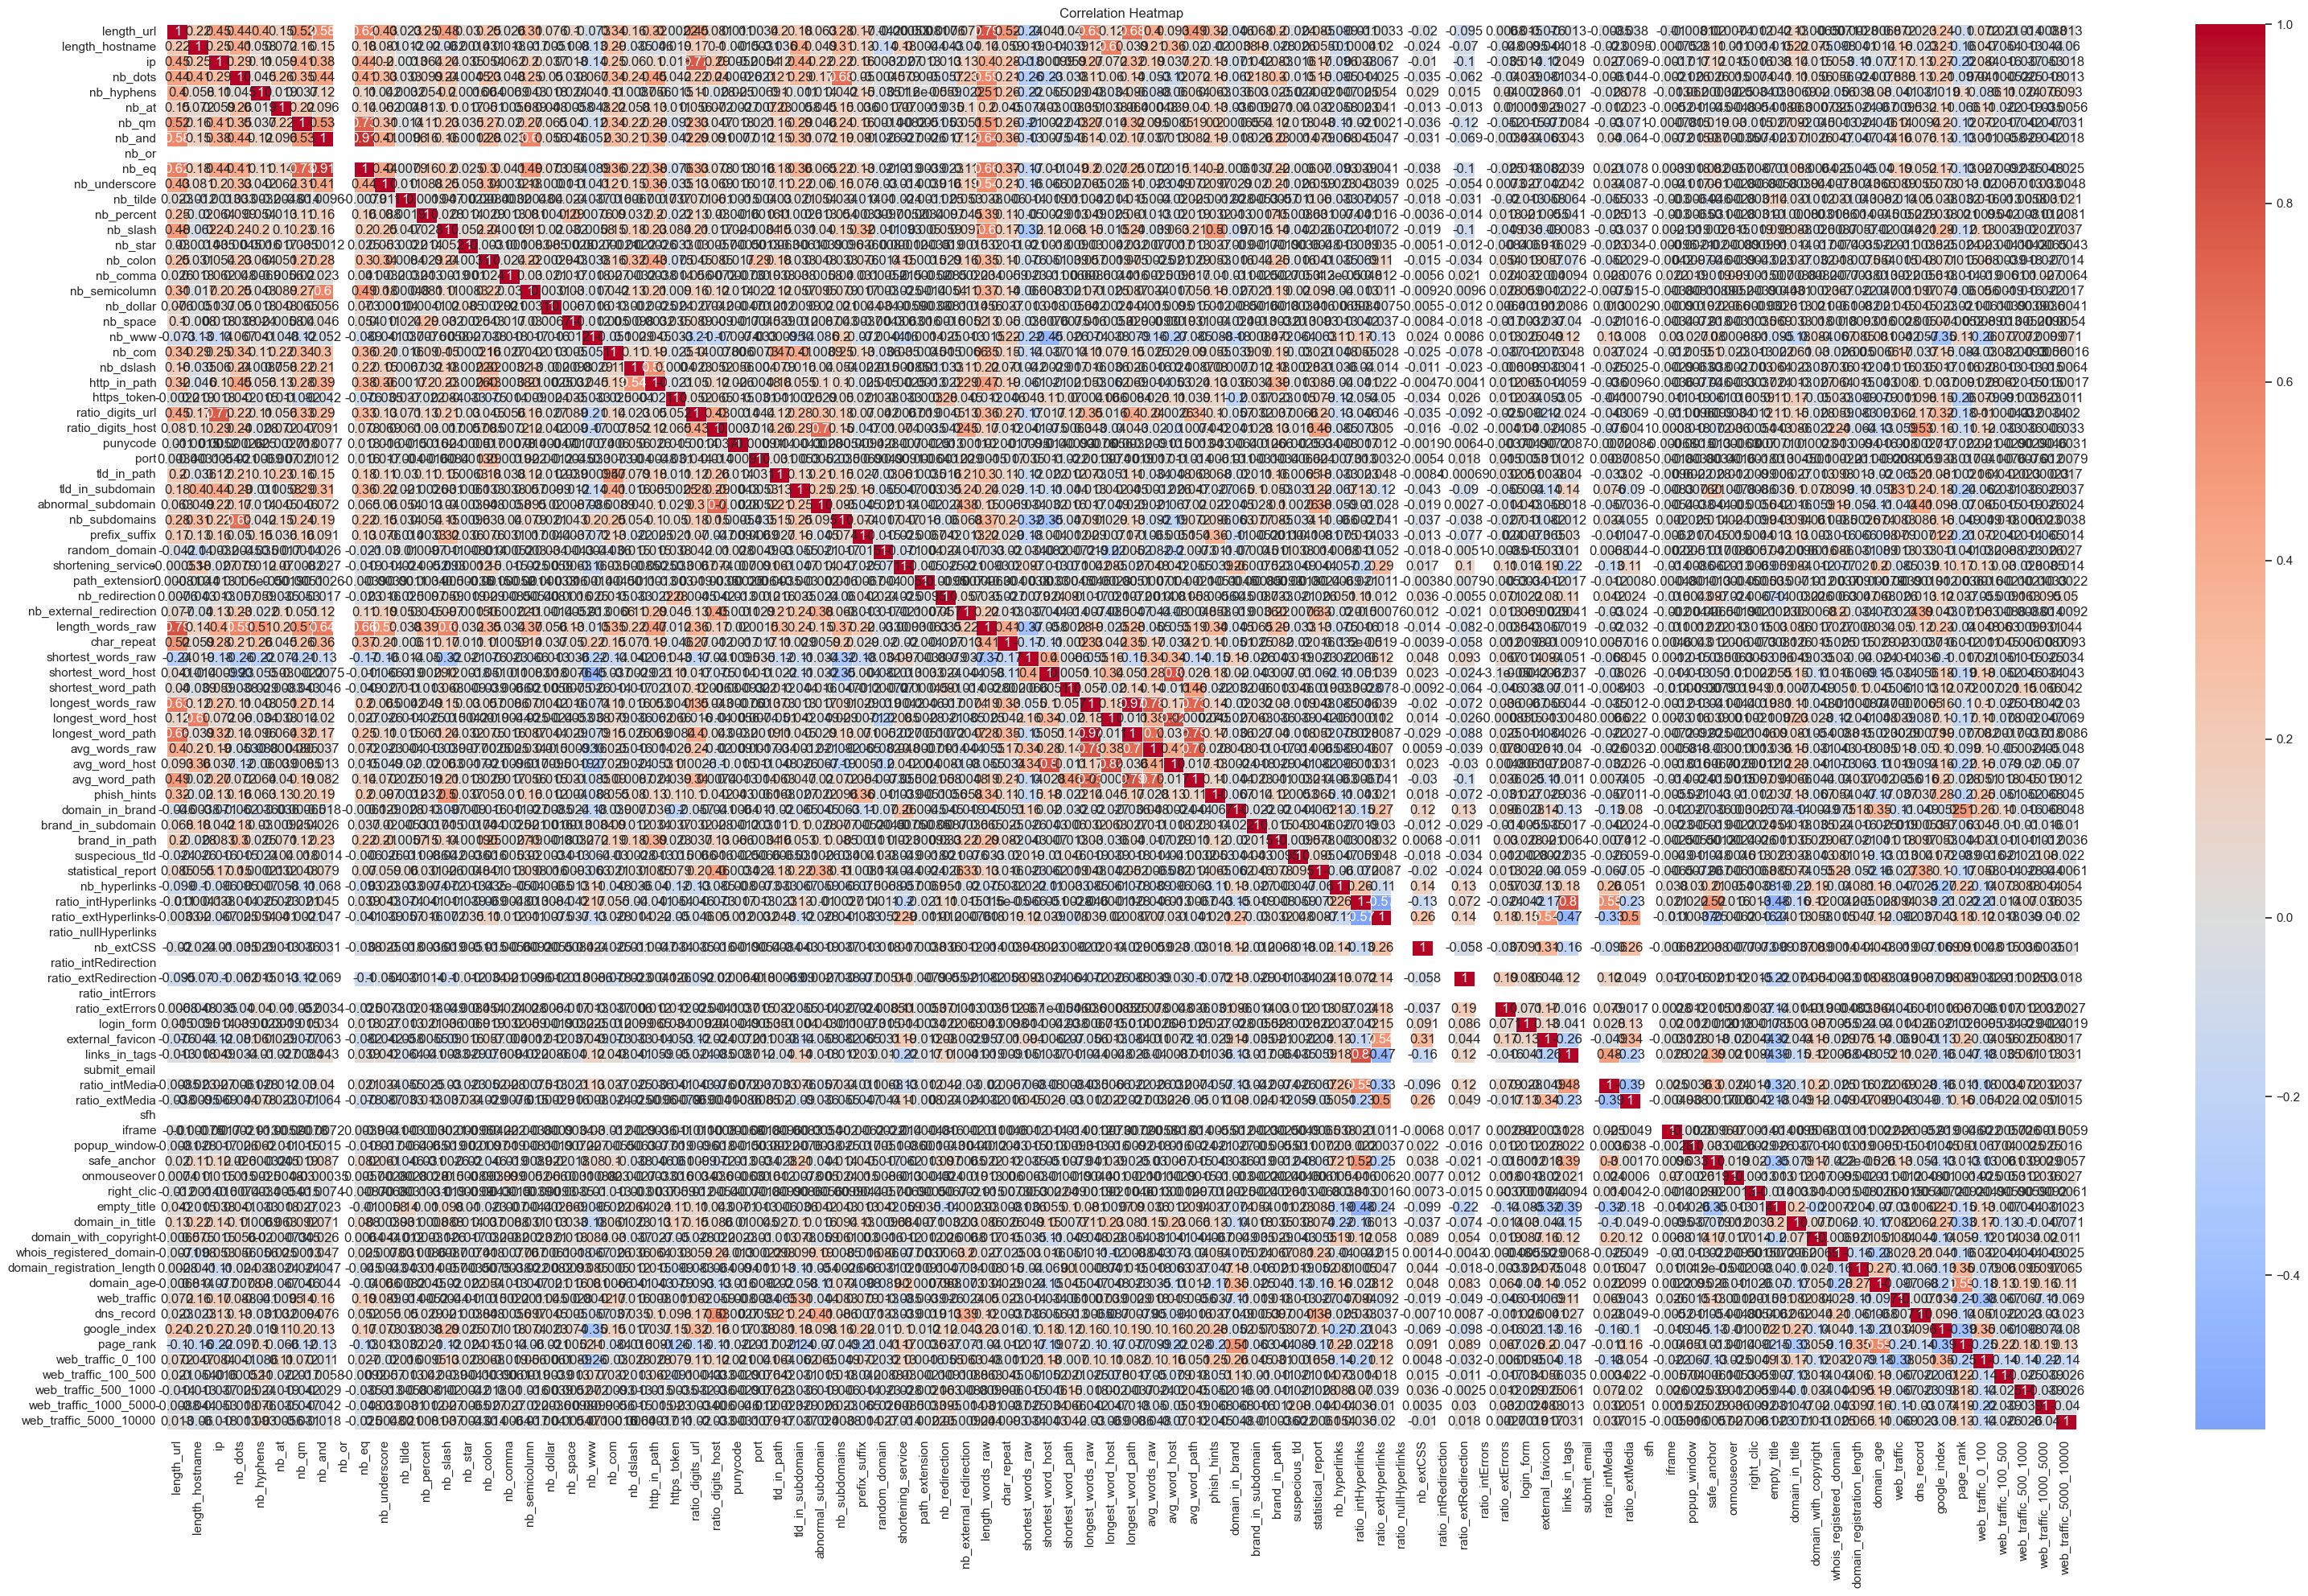

Top 3 Highly Correlated Features:
longest_word_path  longest_words_raw    0.968503
nb_eq              nb_and               0.906404
longest_word_host  avg_word_host        0.816313
dtype: float64

Top 3 Weakly Correlated Features:
ratio_intHyperlinks  empty_title           -0.480813
ratio_extHyperlinks  ratio_intHyperlinks   -0.572294
length_url           nb_or                       NaN
dtype: float64


In [62]:
# Calculate the correlation matrix
correlation_matrix = data.drop("url", "status").toPandas().corr()

# Set up Seaborn and Matplotlib parameters for spacing
plt.figure(figsize=(32, 20))
sns.set(rc={"axes.facecolor": "#FFFFFF", "figure.facecolor": "#FFFFFF"})  # Set background color

# Create a heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=.5)
plt.title("Correlation Heatmap")
plt.tight_layout()  # Adjust spacing between plot elements
plt.show()

# Identify top 3 highly correlated features
n = 3  # Number of top correlated features to display
top_corr_features = correlation_matrix.unstack().sort_values(ascending=False).drop_duplicates()
top_corr_features = top_corr_features[top_corr_features != 1]  # Remove self-correlations
top_high_corr = top_corr_features.head(n)

# Identify top 3 weakly correlated features
top_weak_corr = top_corr_features.tail(n)

print("Top", n, "Highly Correlated Features:")
print(top_high_corr)

print("\nTop", n, "Weakly Correlated Features:")
print(top_weak_corr)



### Distribution of each feature

/Users/maladeep/miniforge3/envs/bigdata/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 25312 (\N{CJK UNIFIED IDEOGRAPH-62E0}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maladeep/miniforge3/envs/bigdata/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20613 (\N{CJK UNIFIED IDEOGRAPH-5085}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maladeep/miniforge3/envs/bigdata/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 131 (\x83) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maladeep/miniforge3/envs/bigdata/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 130 (\x82) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/maladeep/miniforge3/envs/bigdata/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 145 (\x91) missing from 

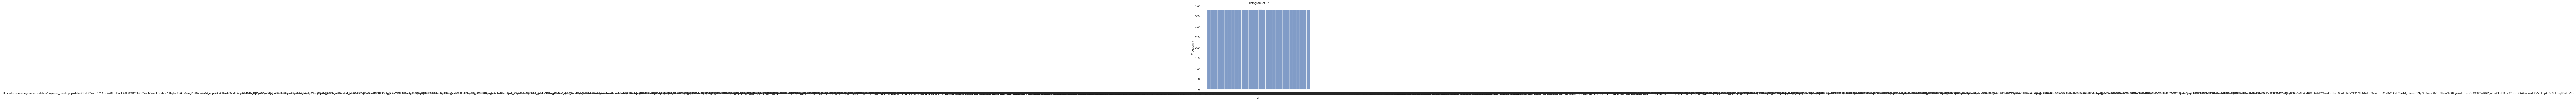

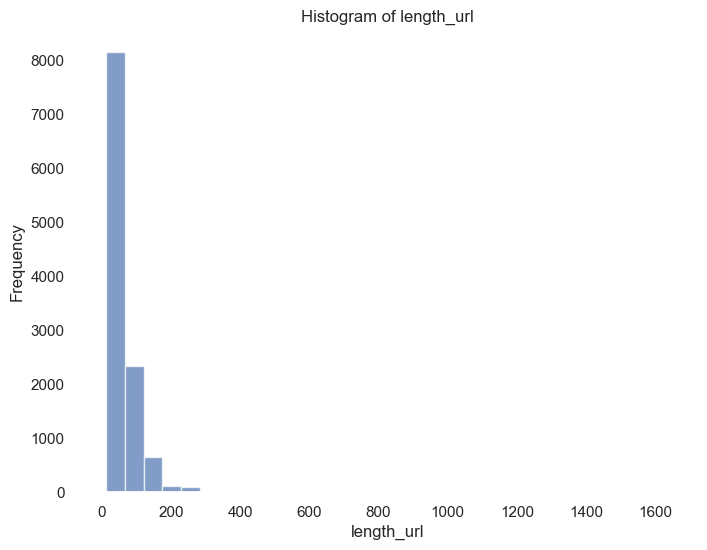

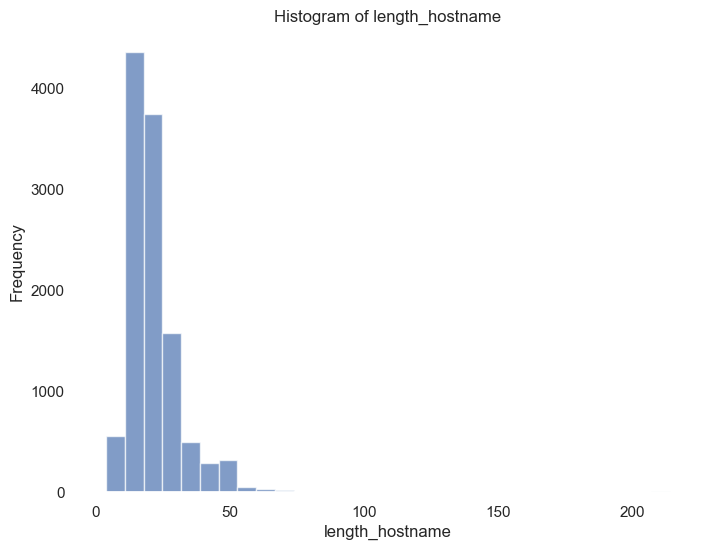

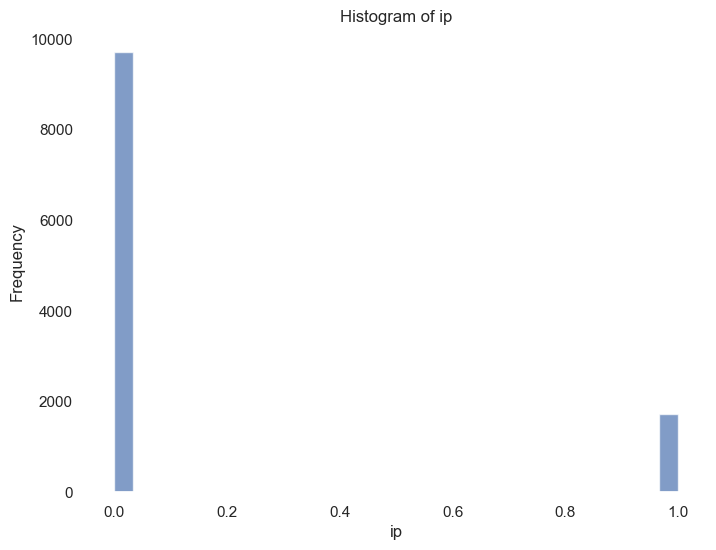

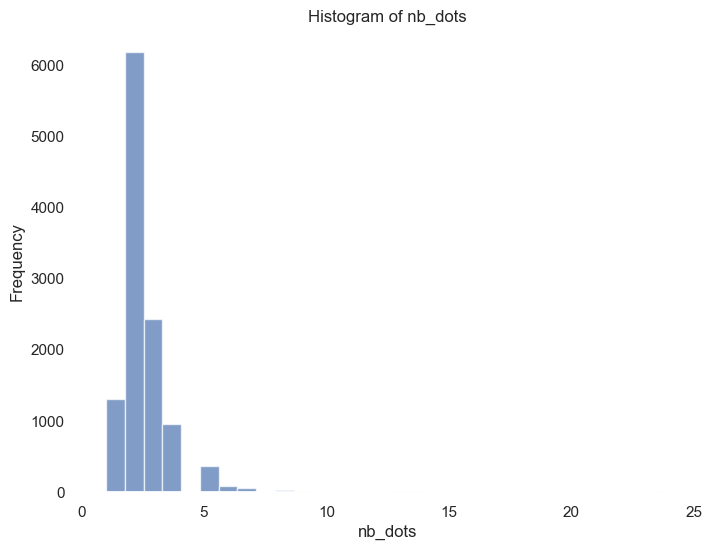

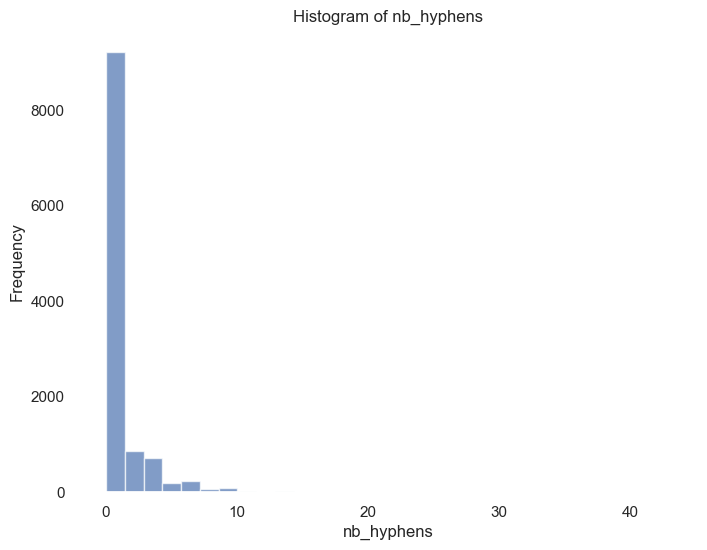

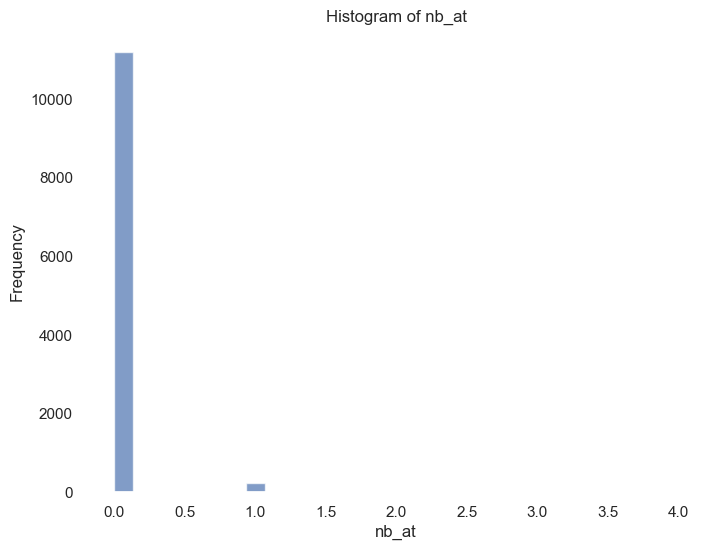

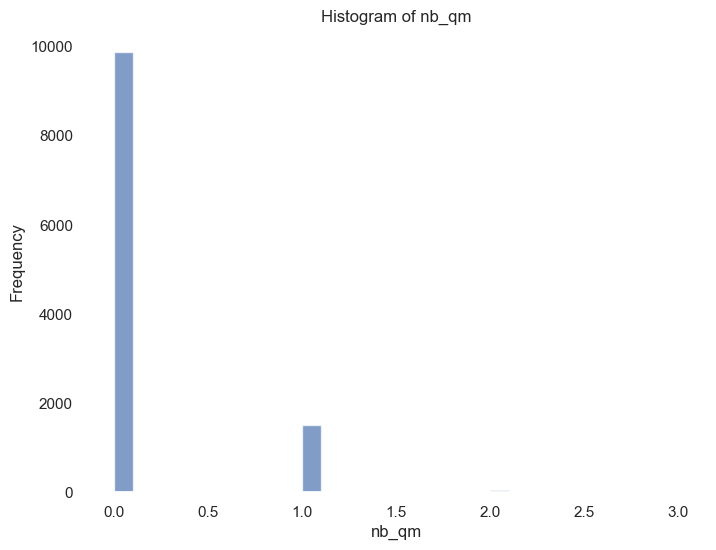

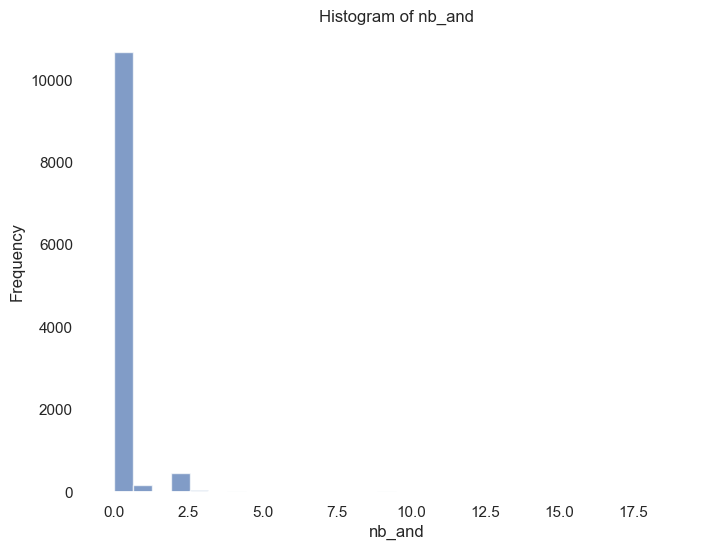

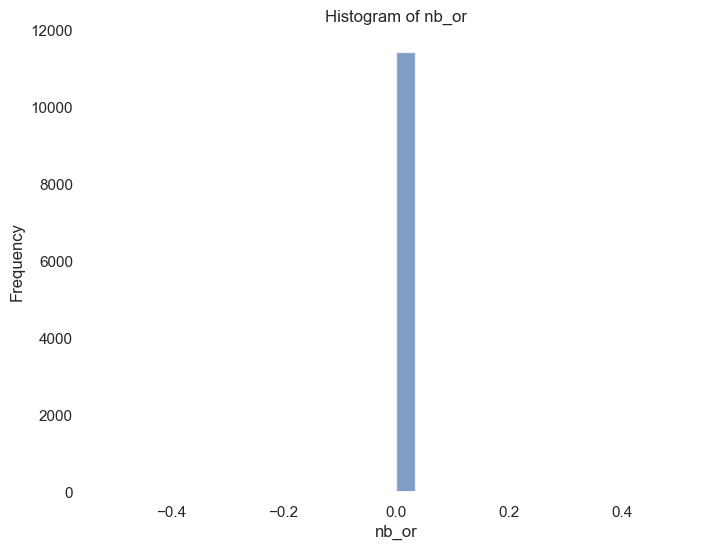

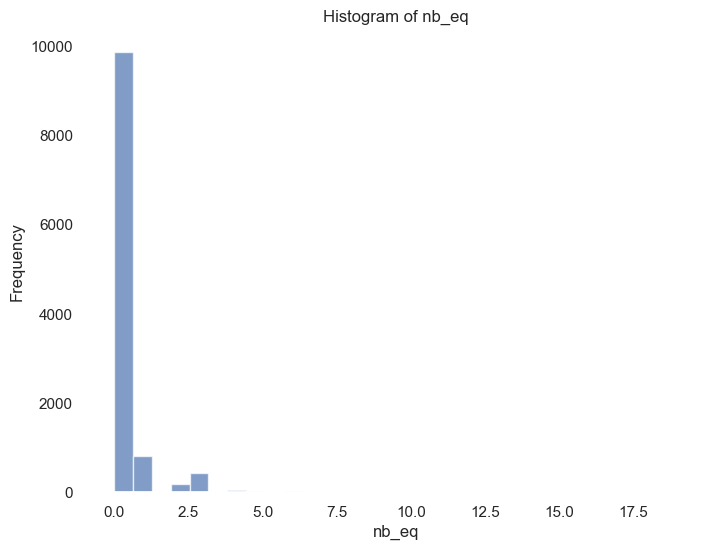

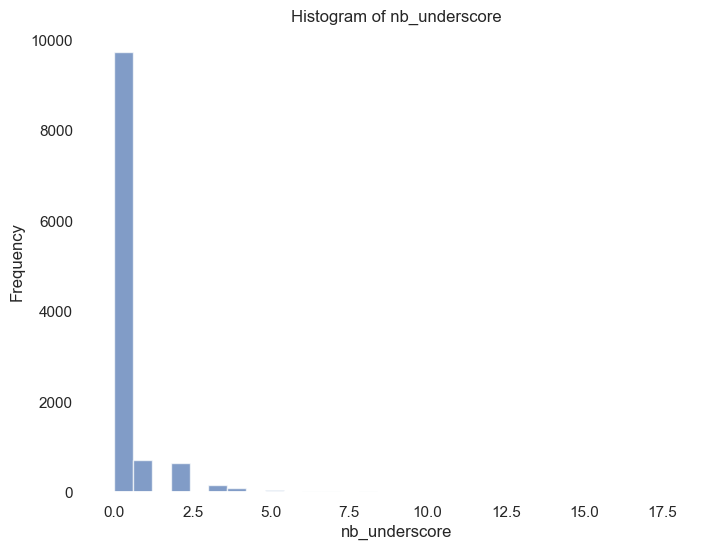

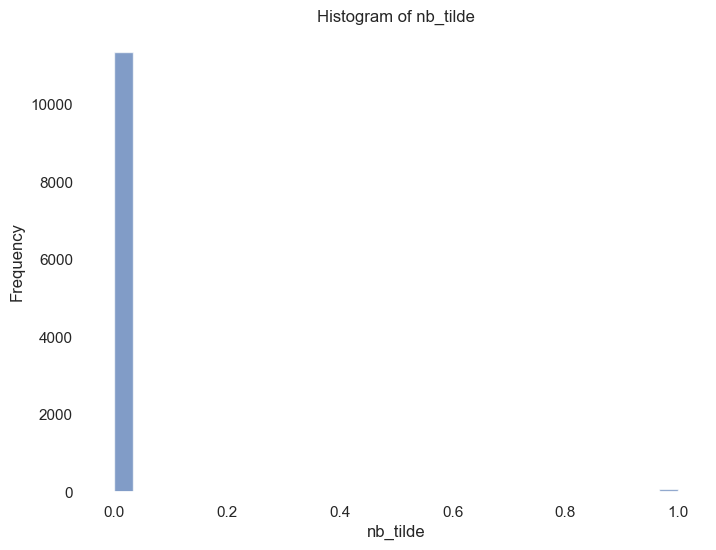

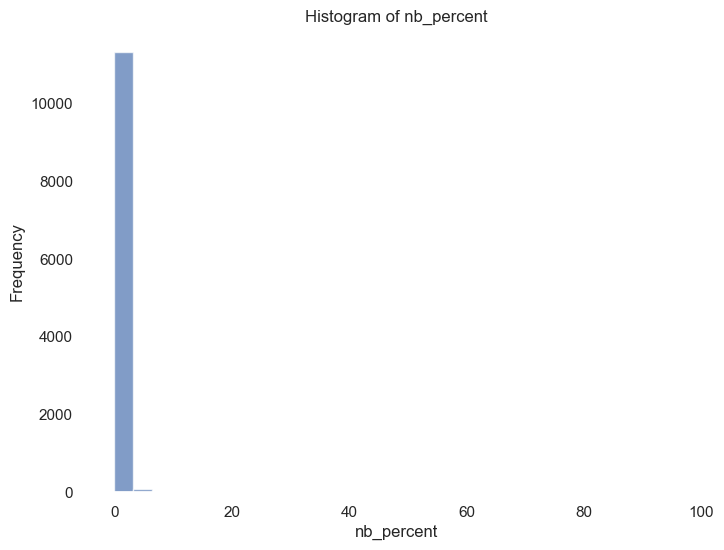

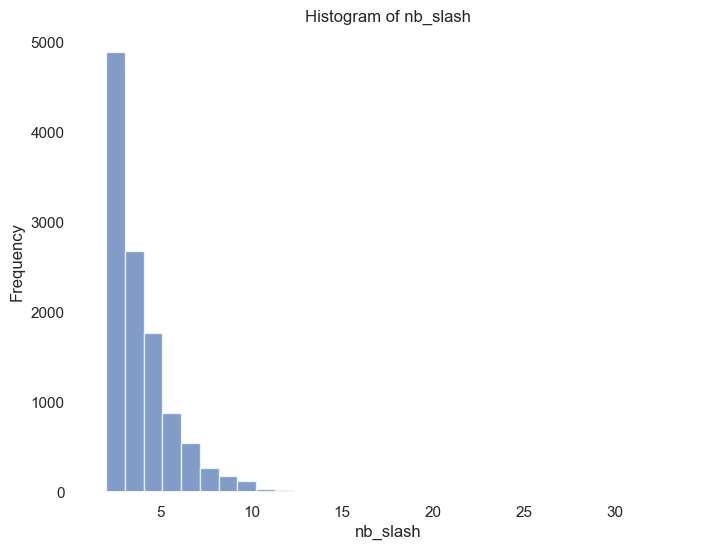

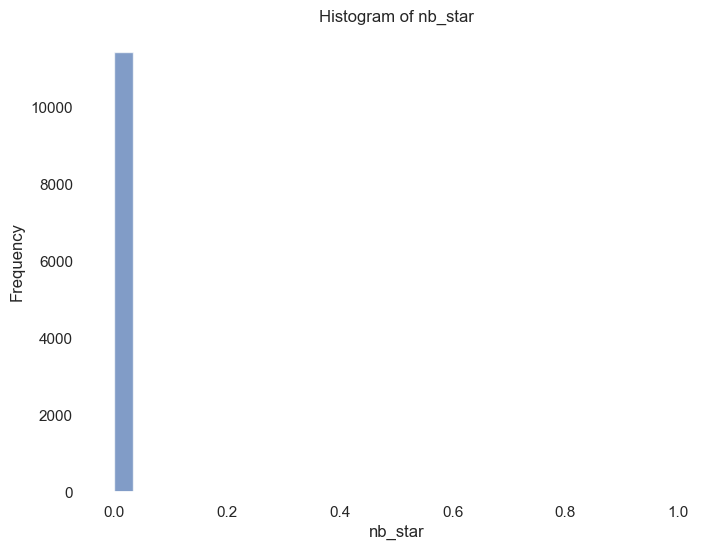

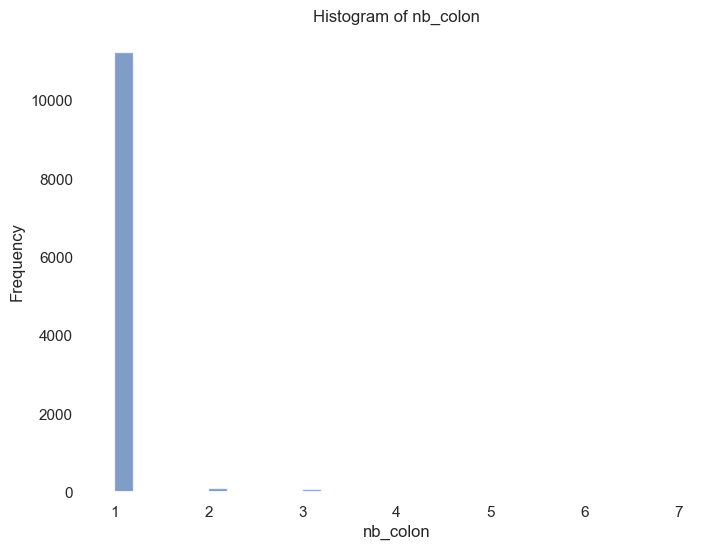

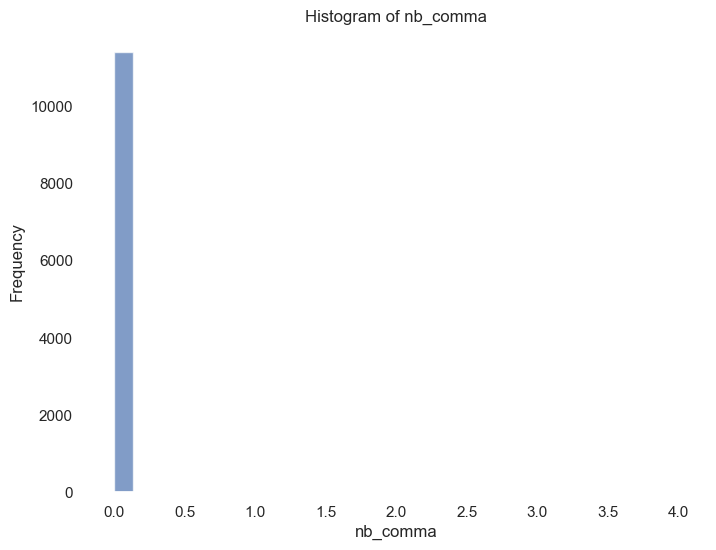

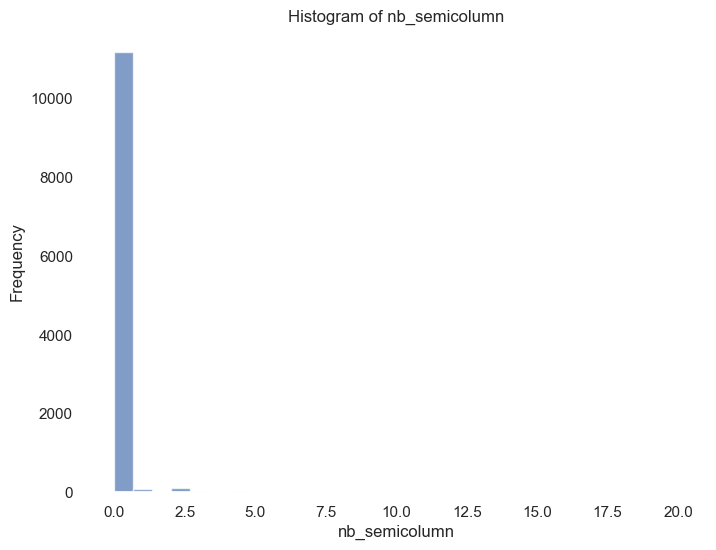

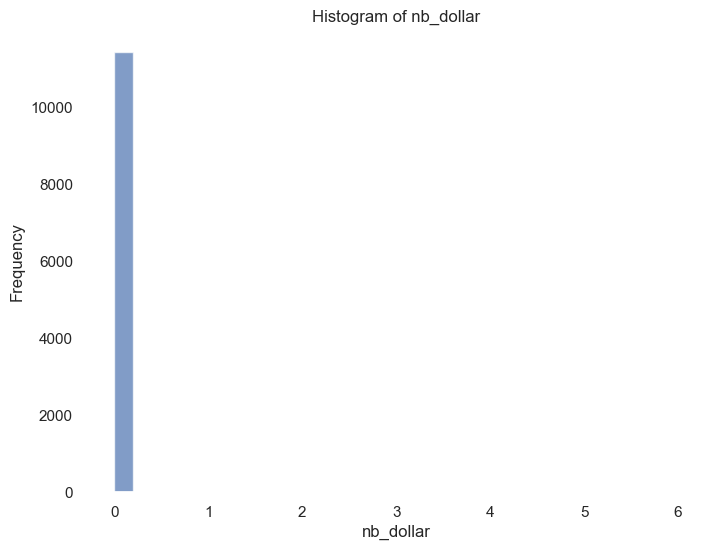

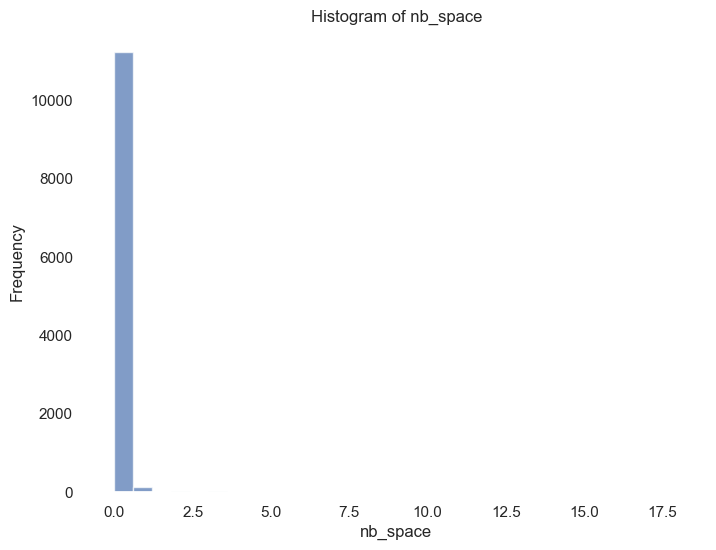

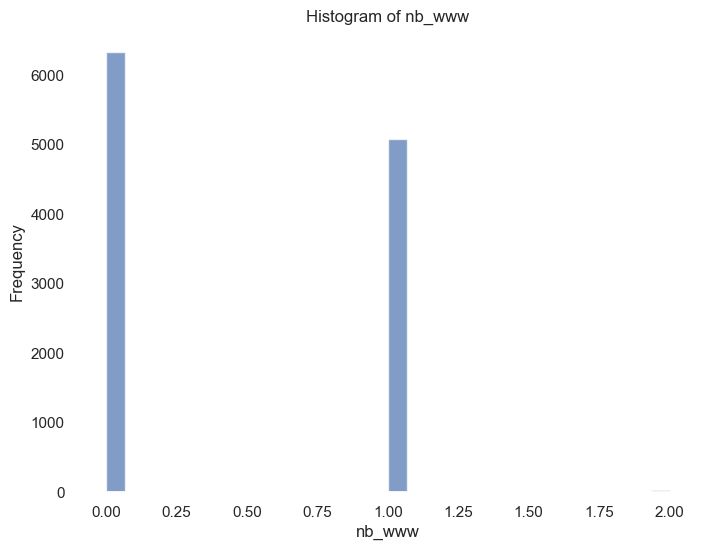

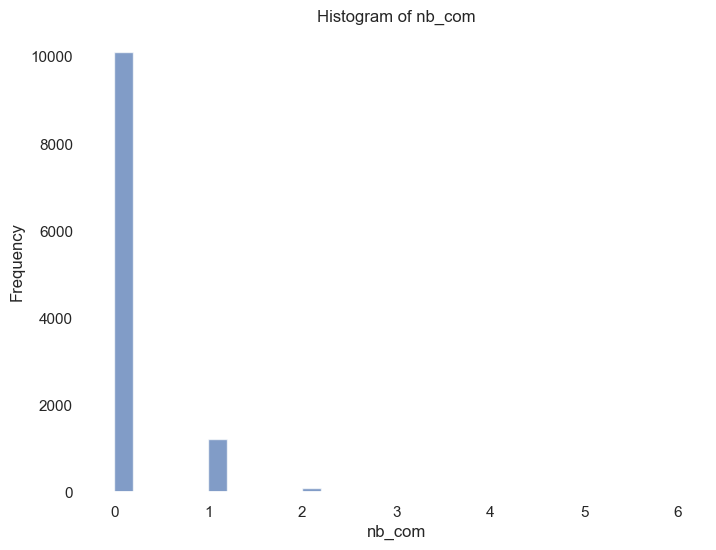

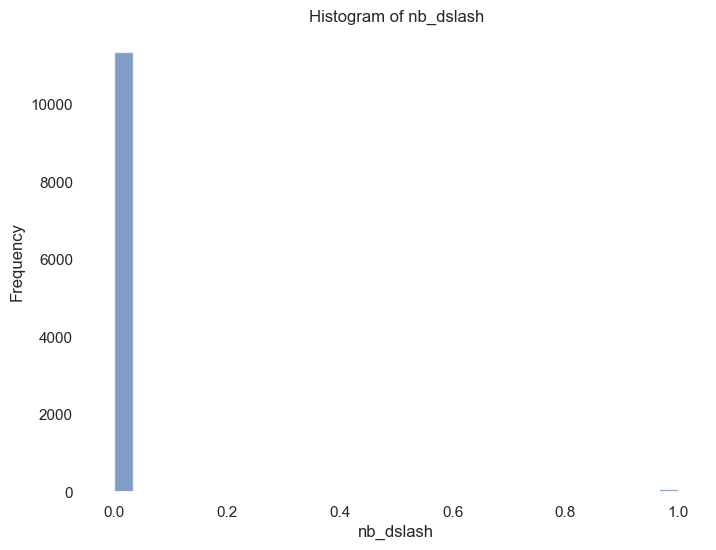

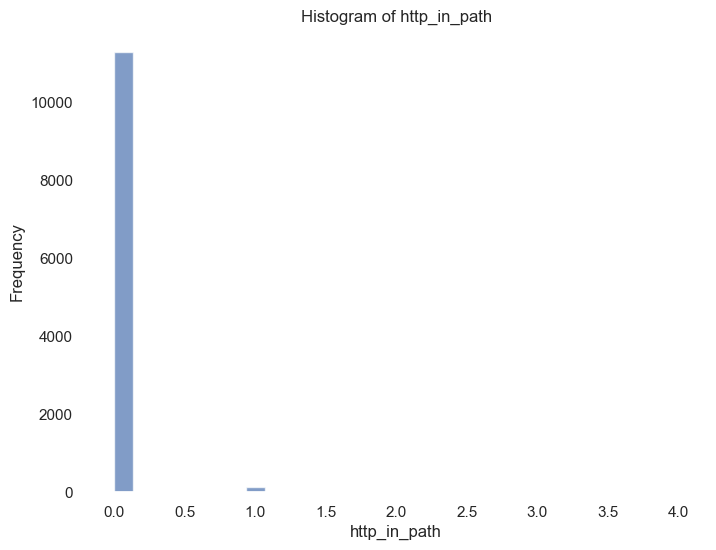

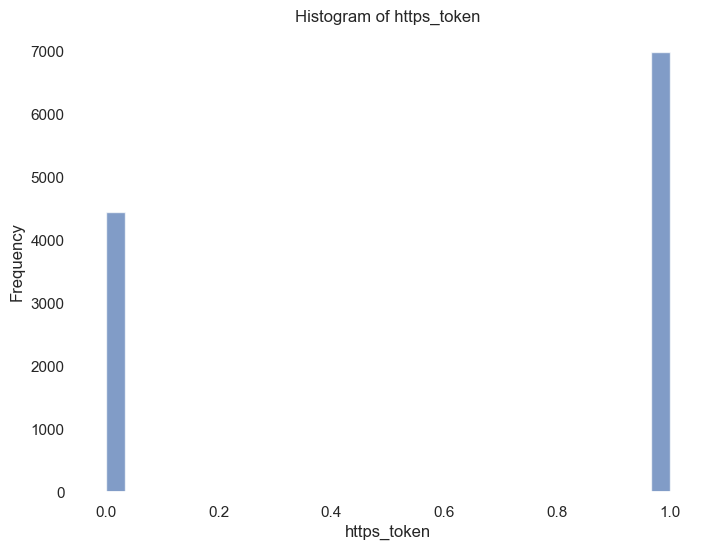

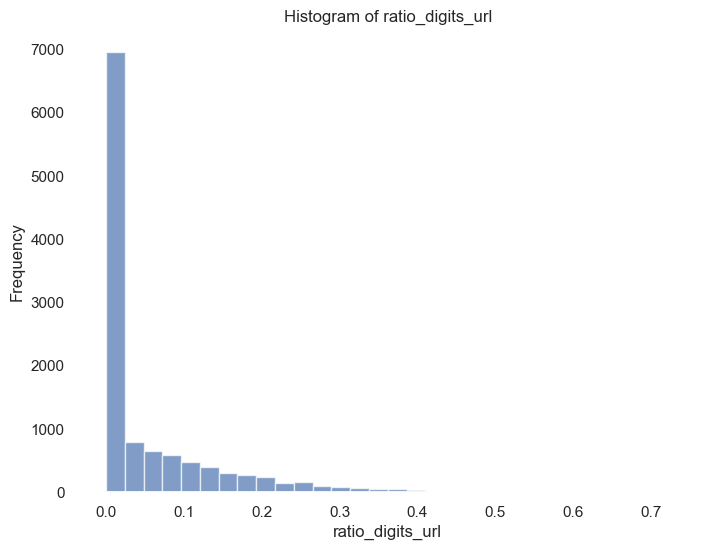

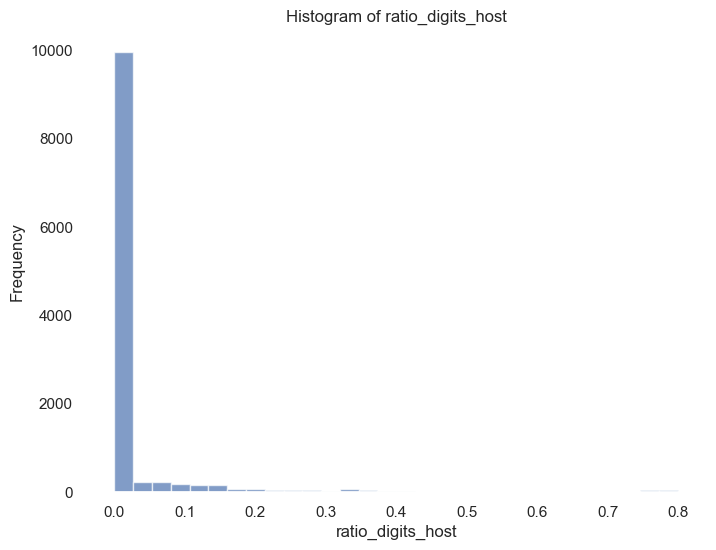

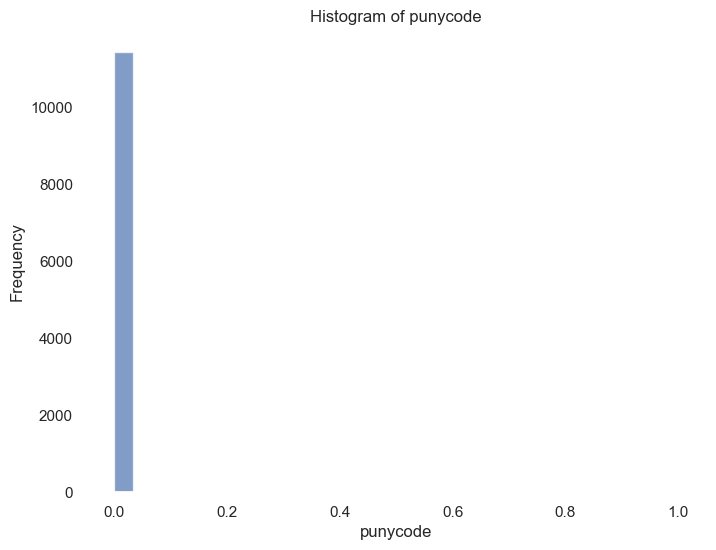

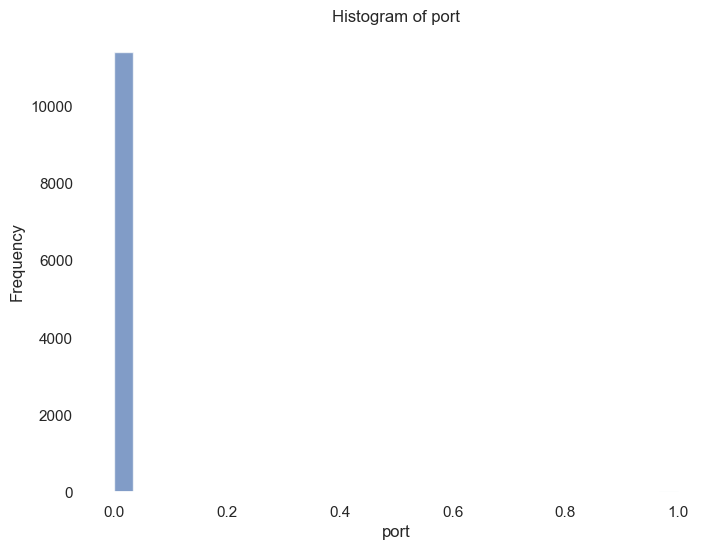

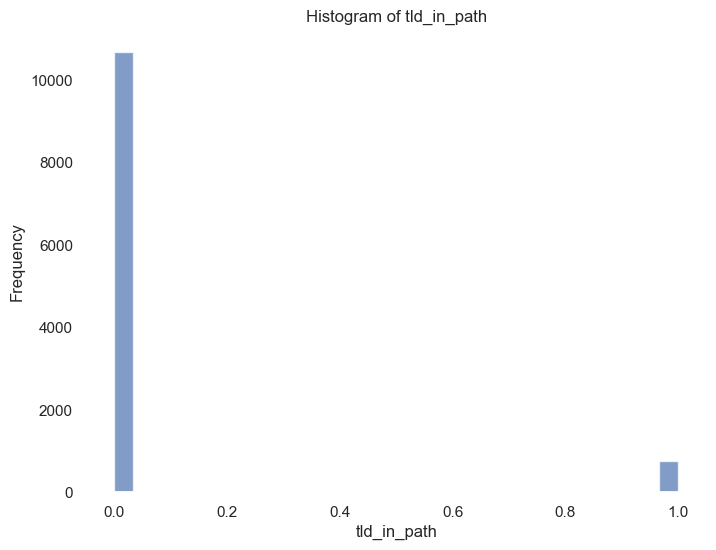

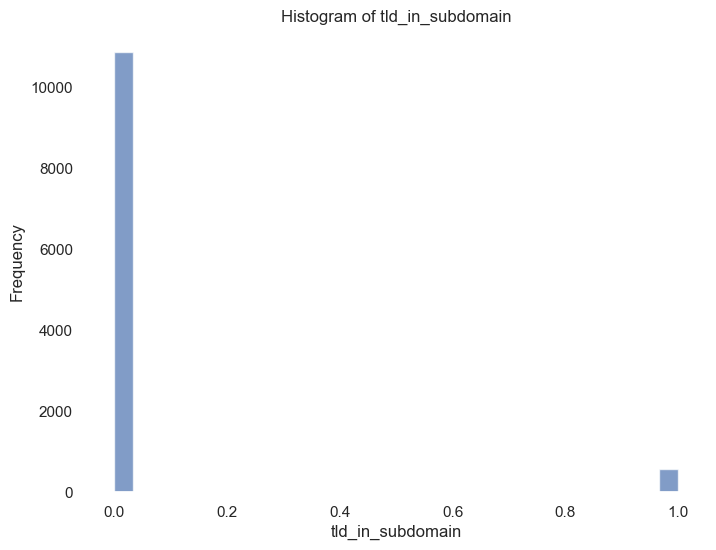

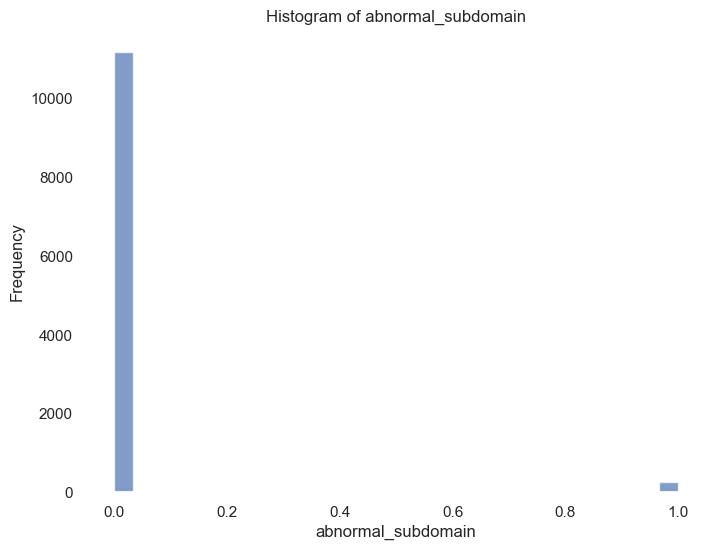

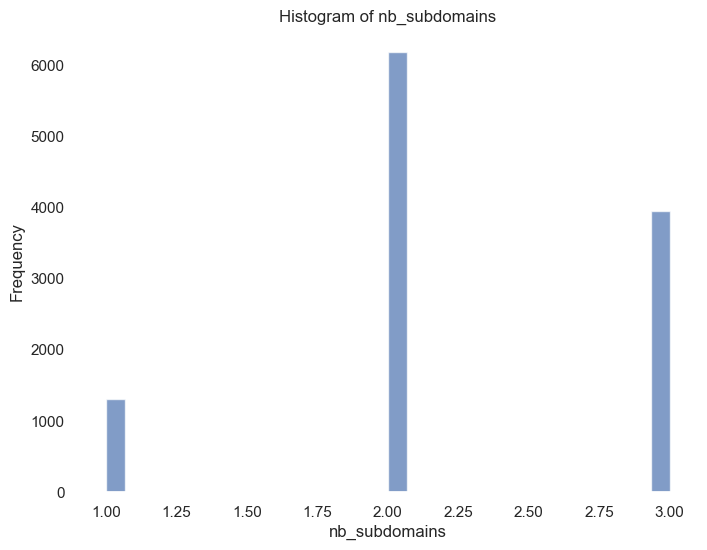

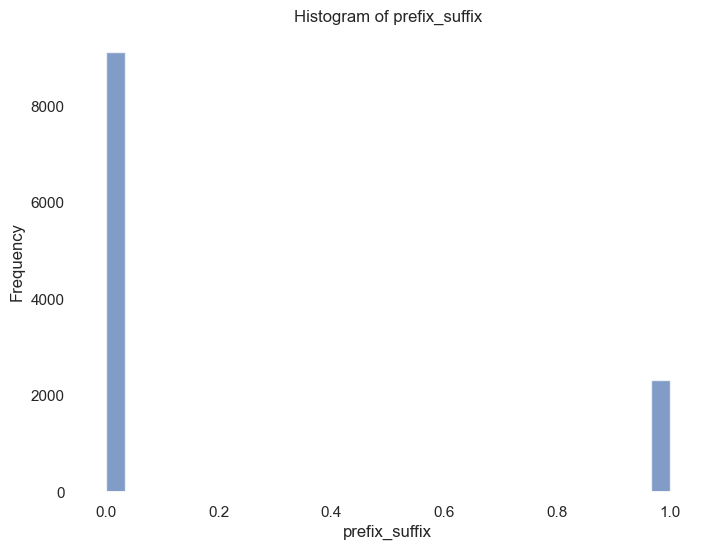

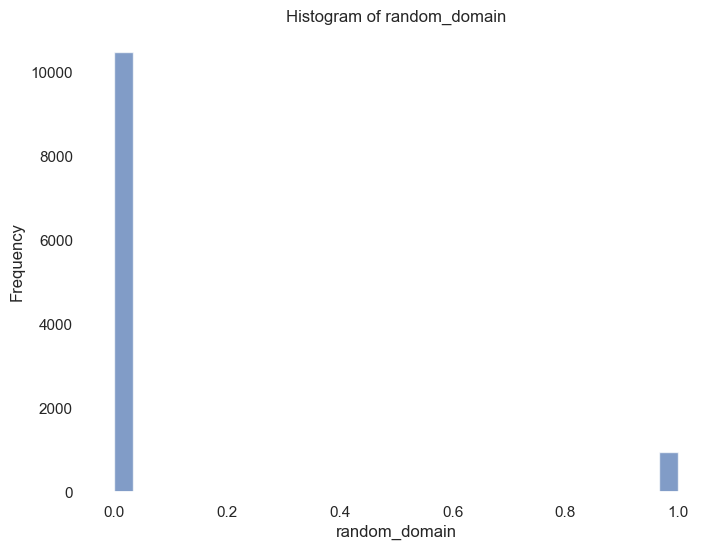

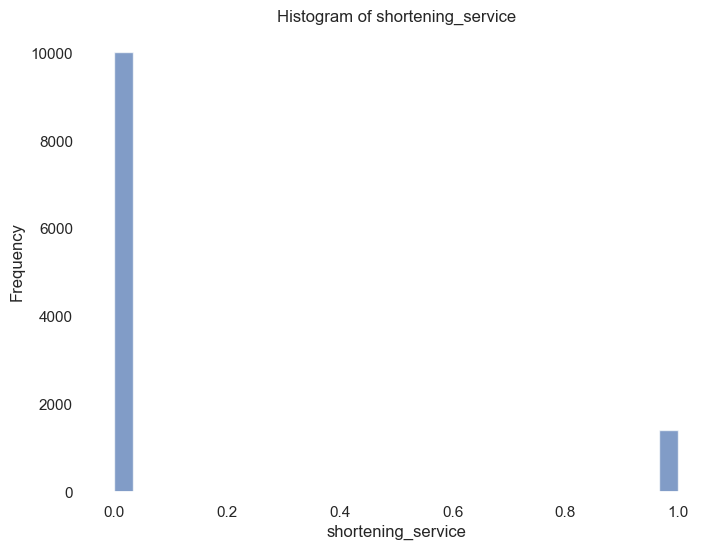

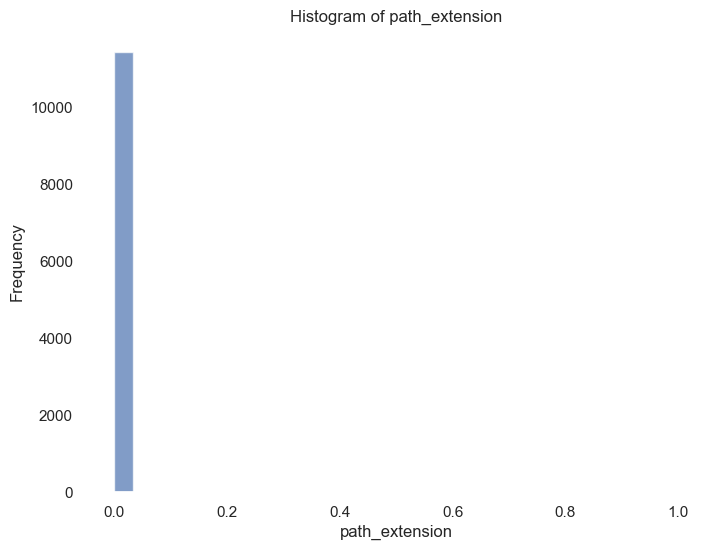

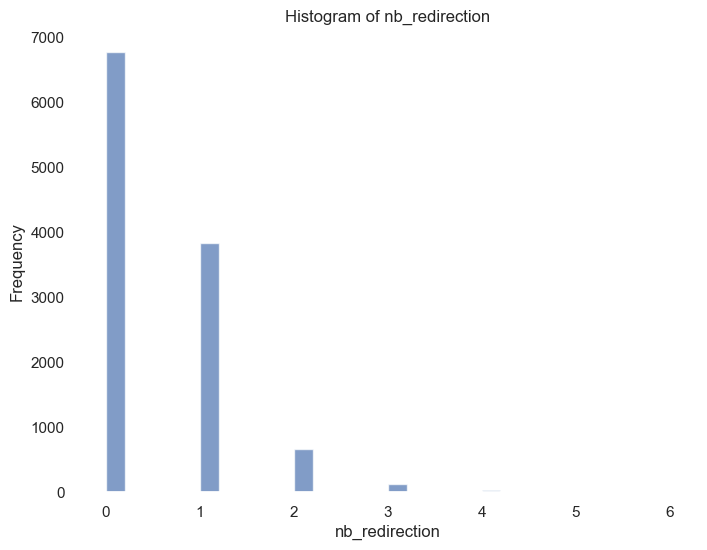

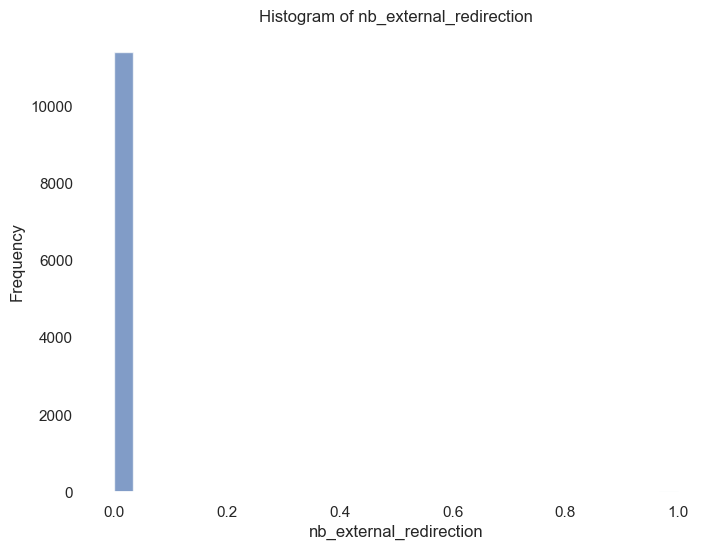

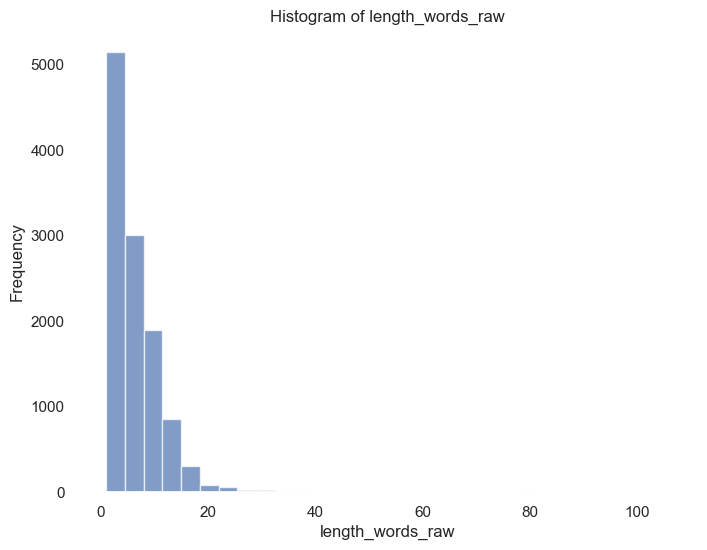

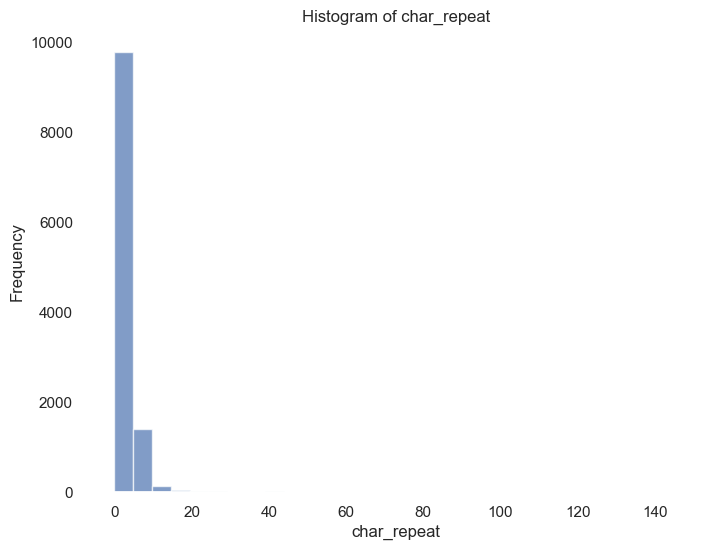

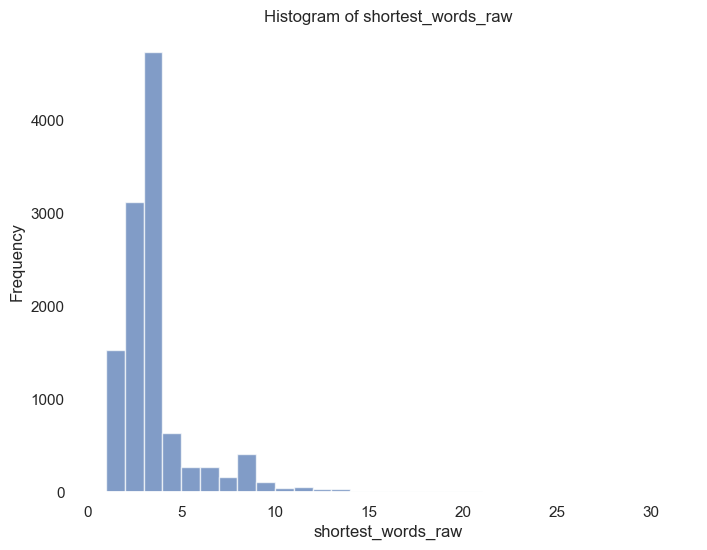

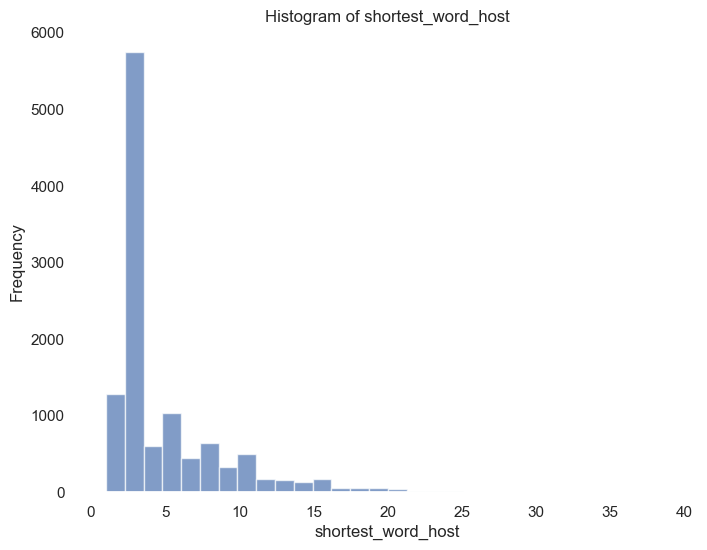

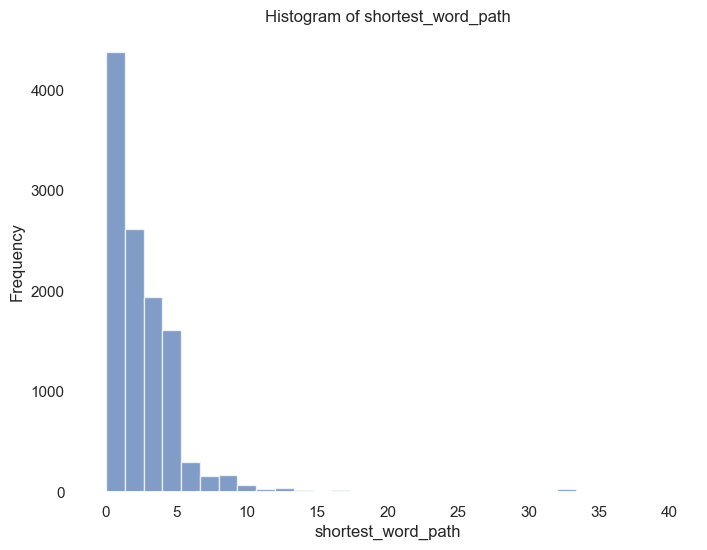

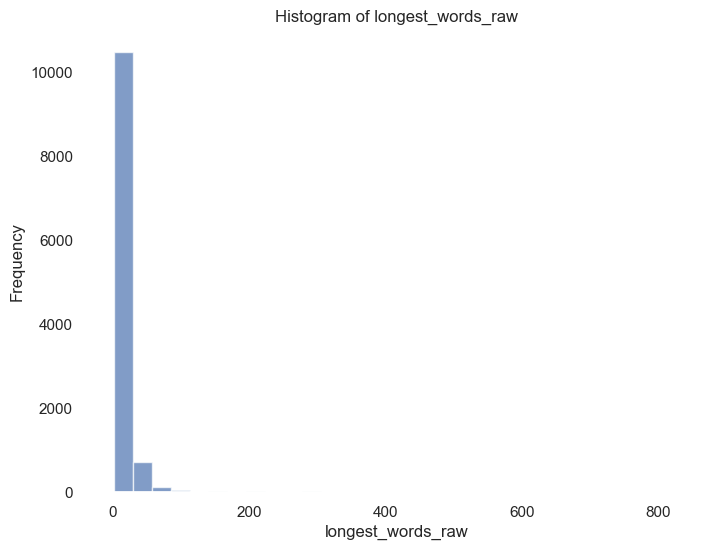

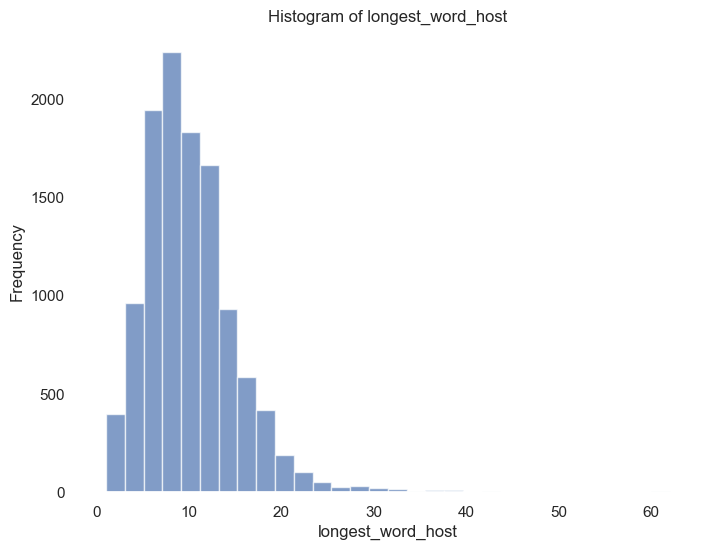

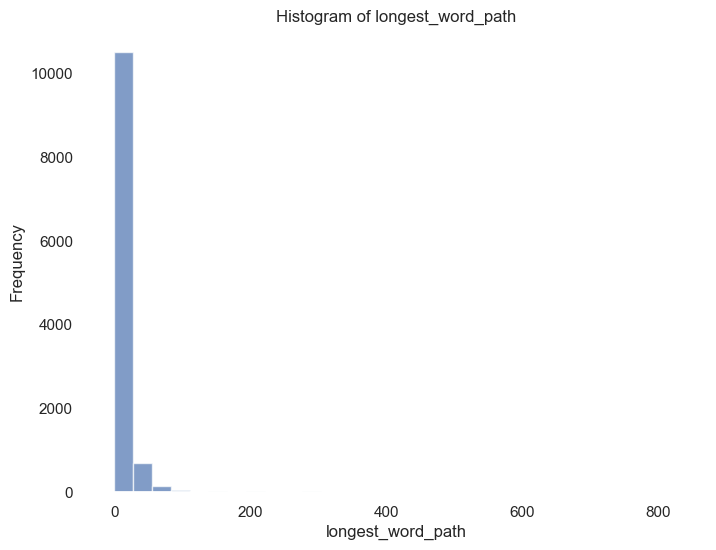

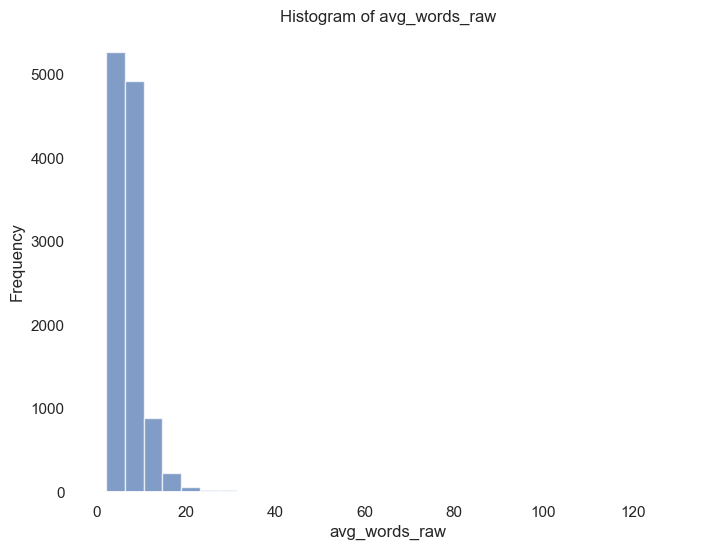

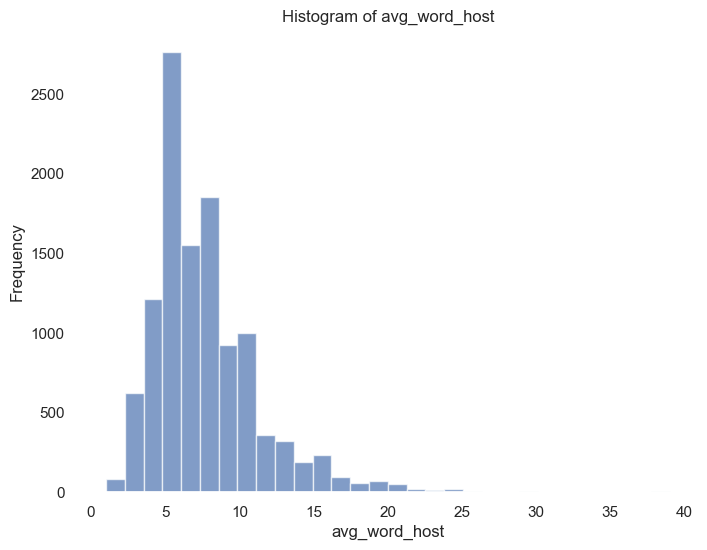

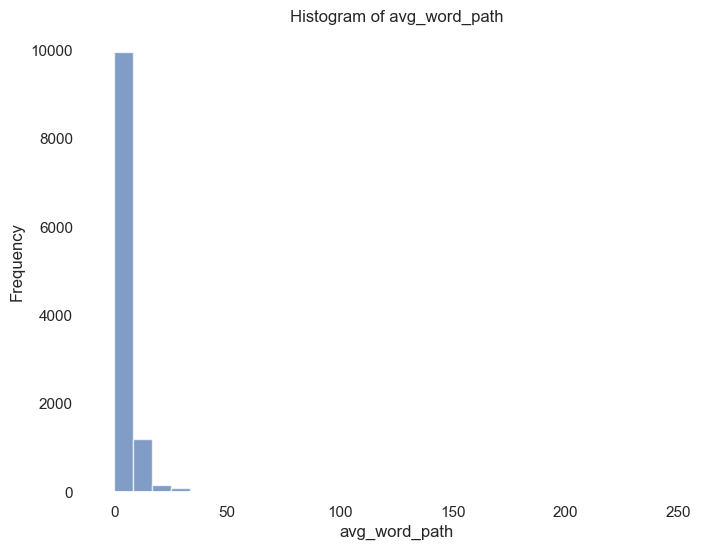

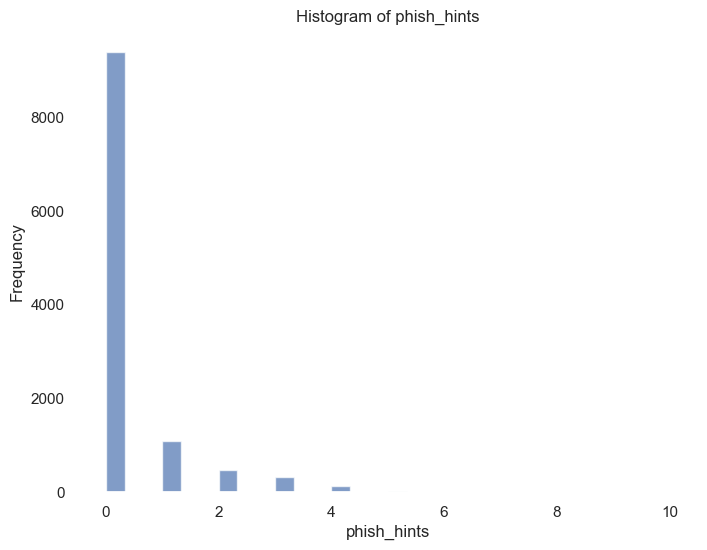

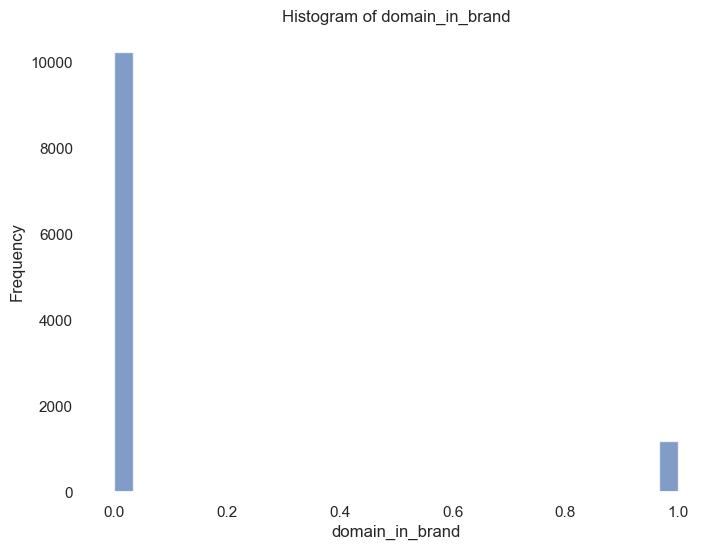

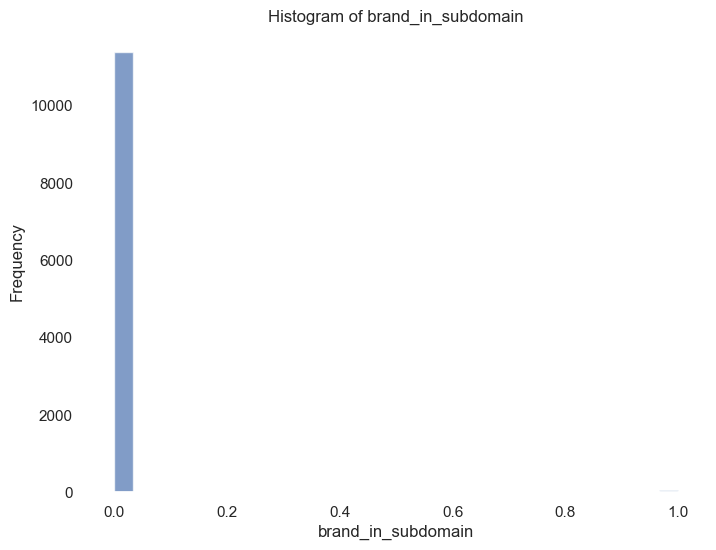

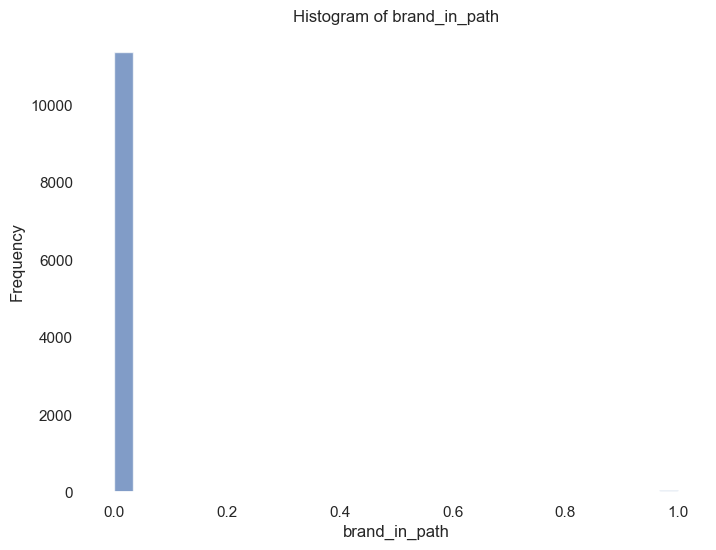

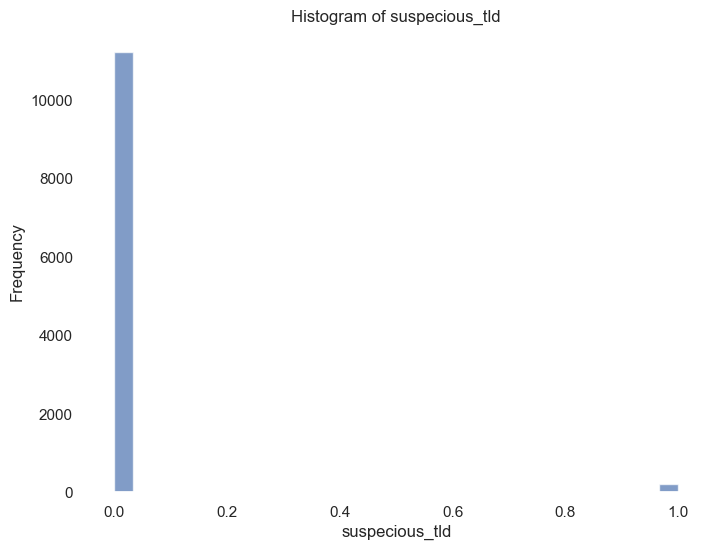

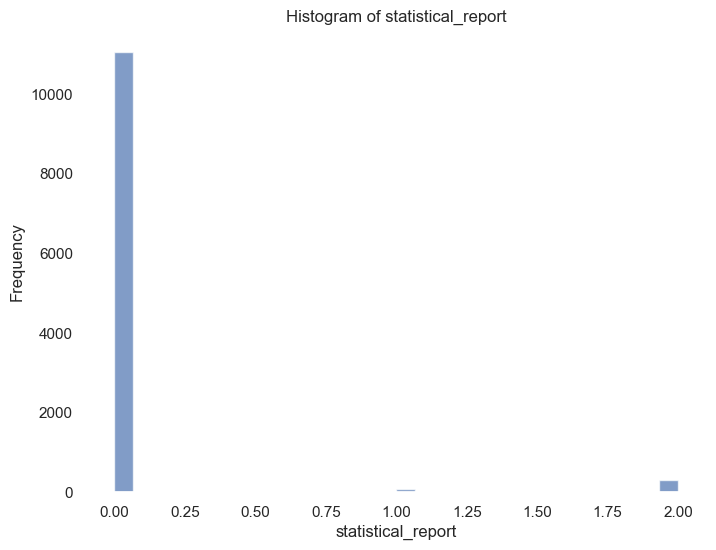

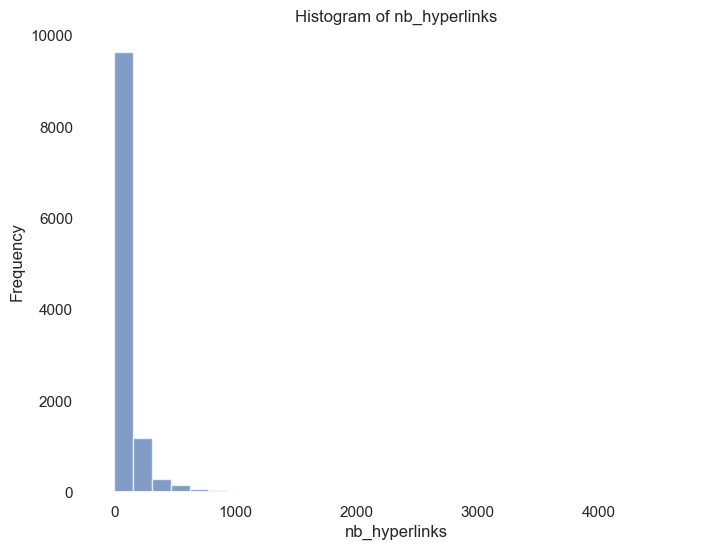

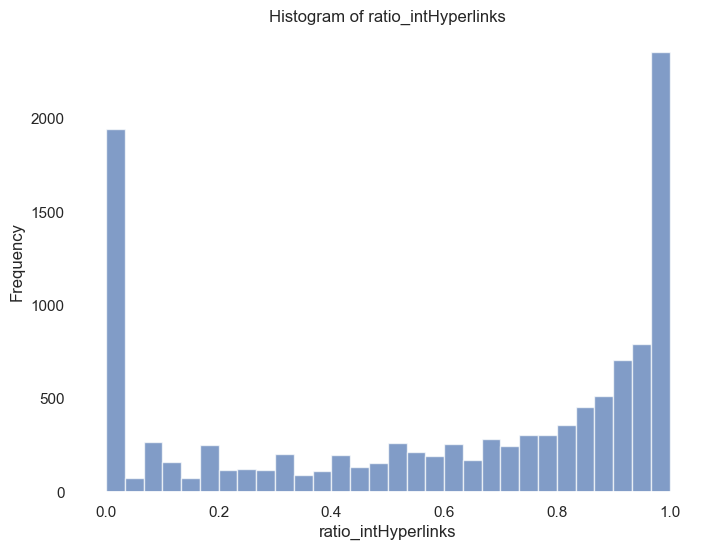

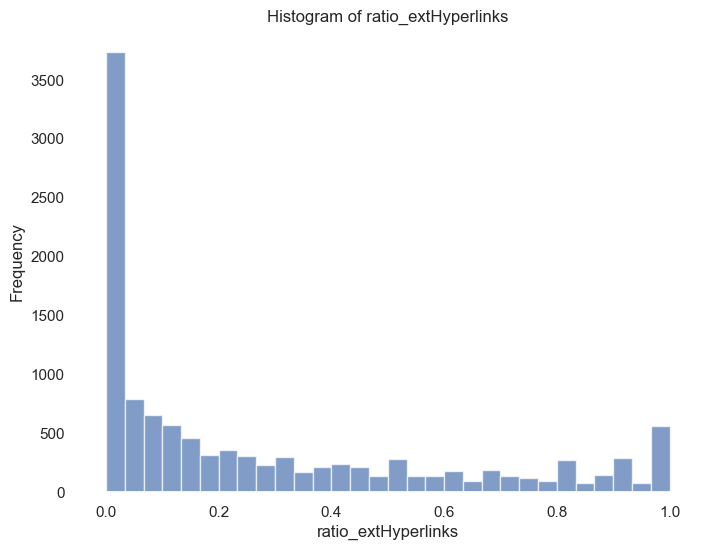

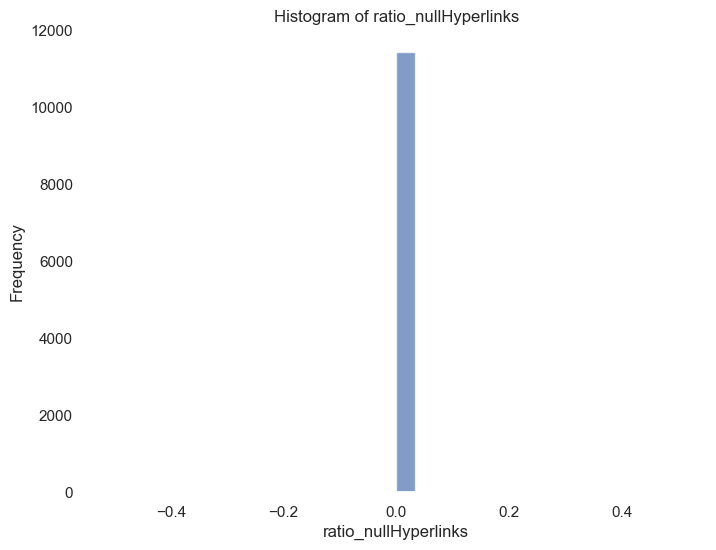

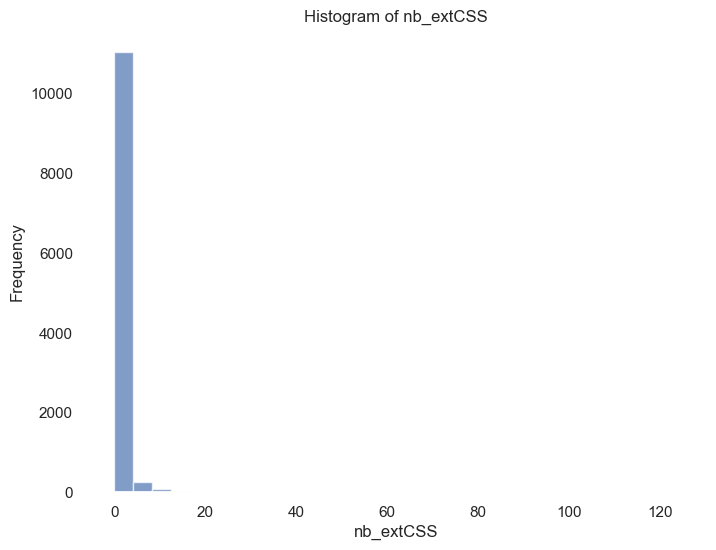

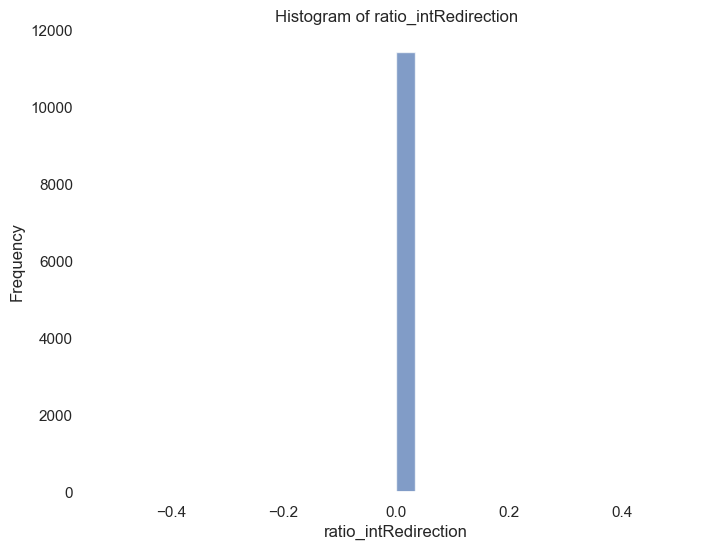

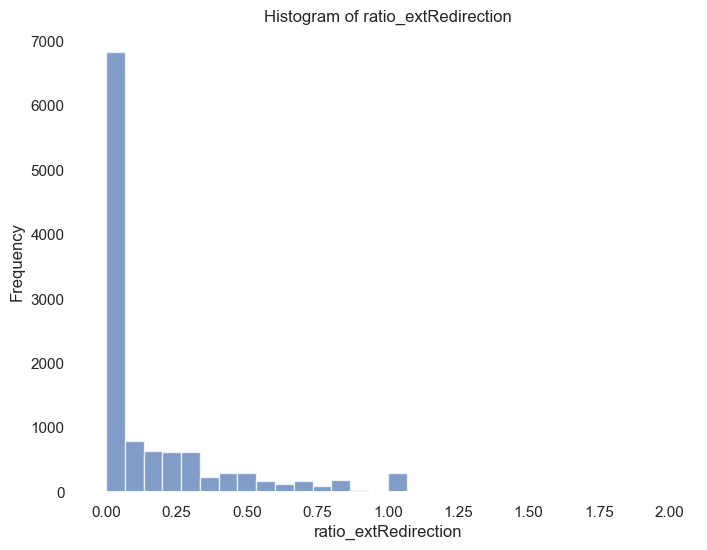

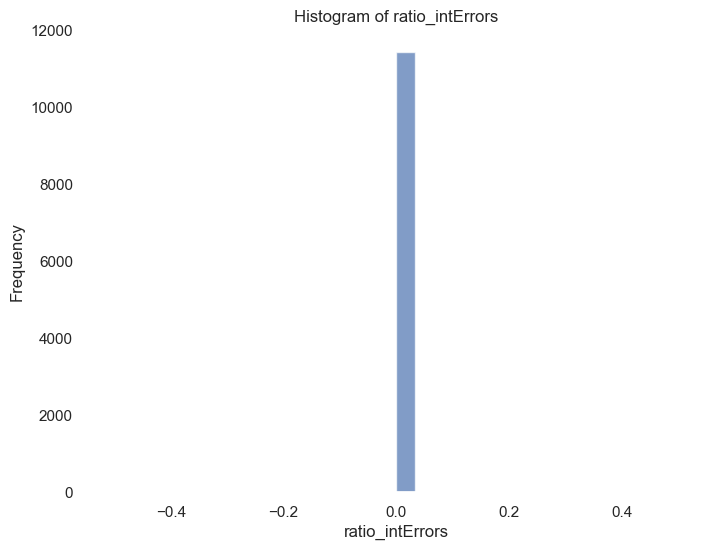

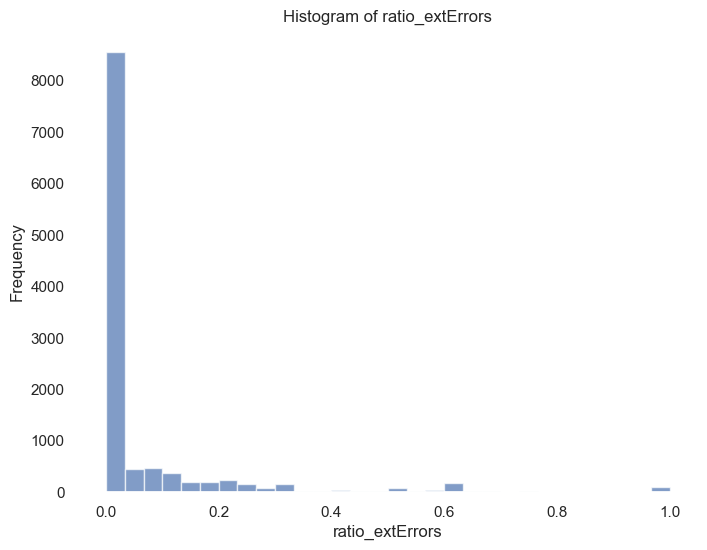

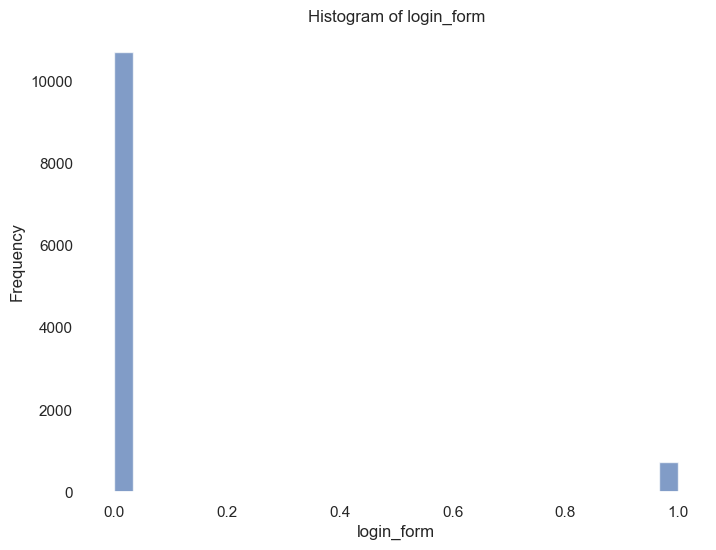

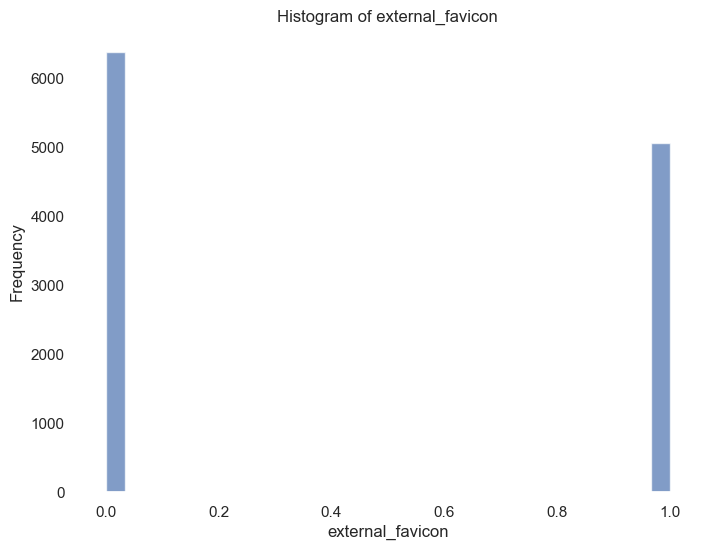

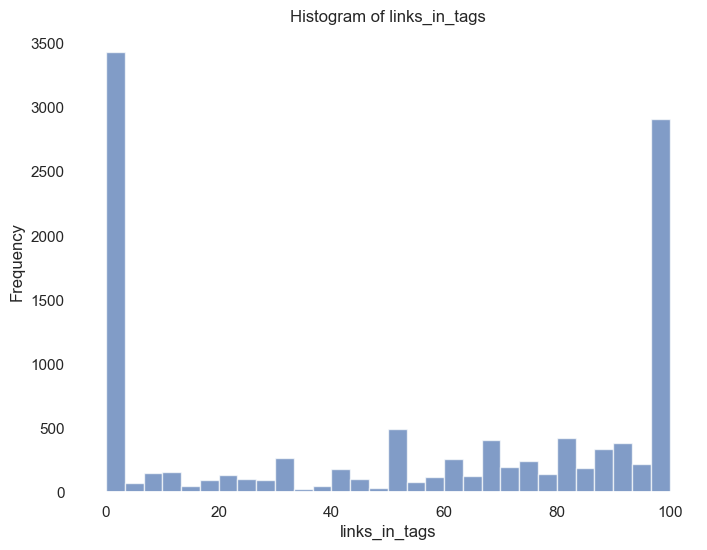

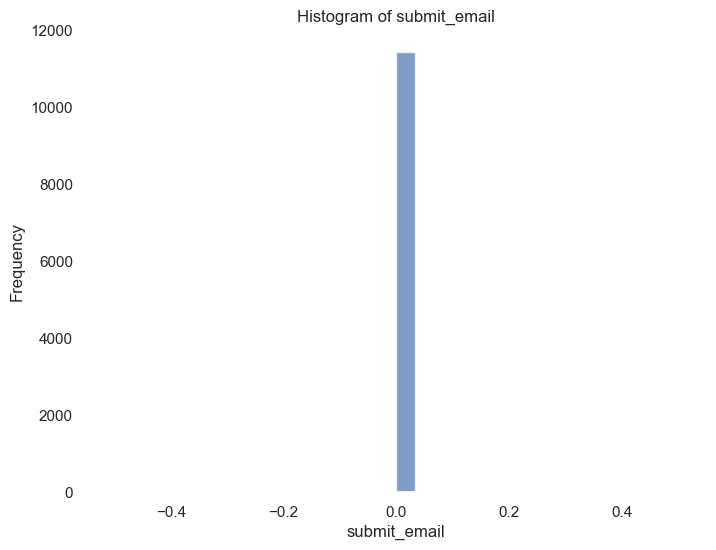

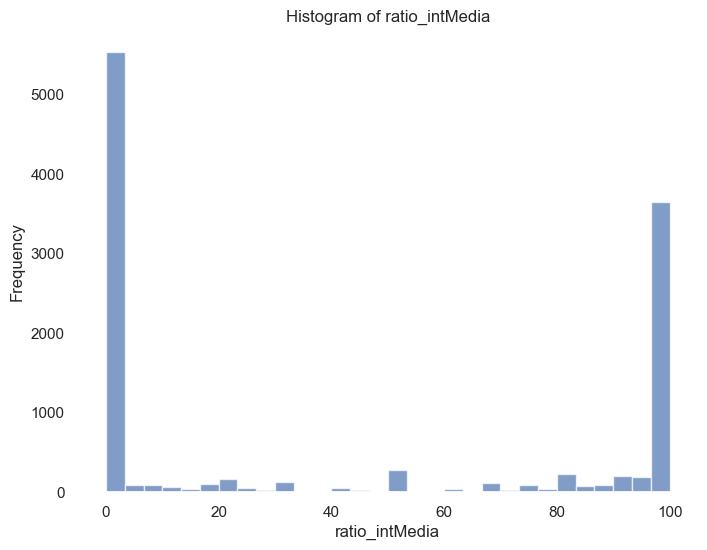

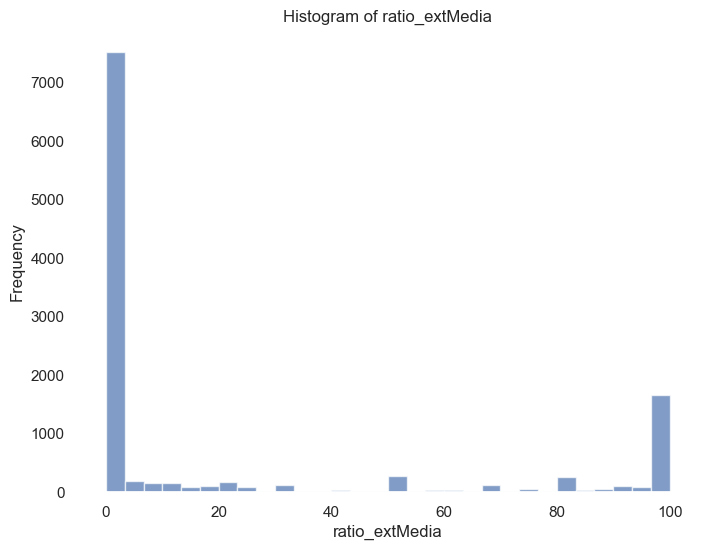

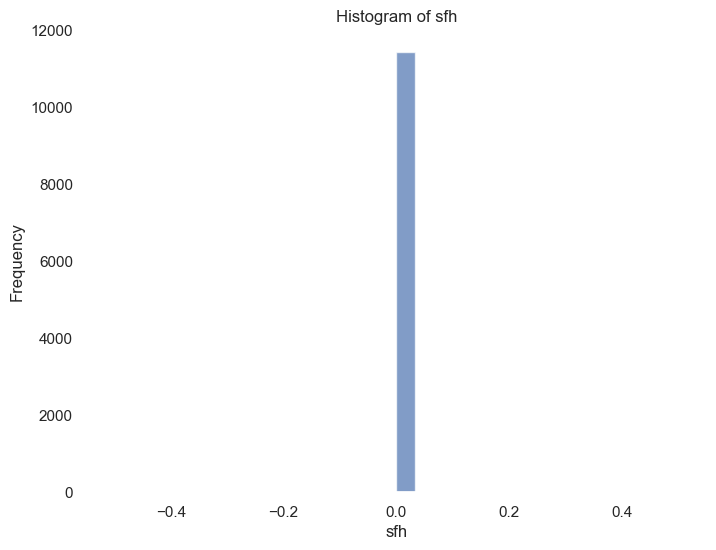

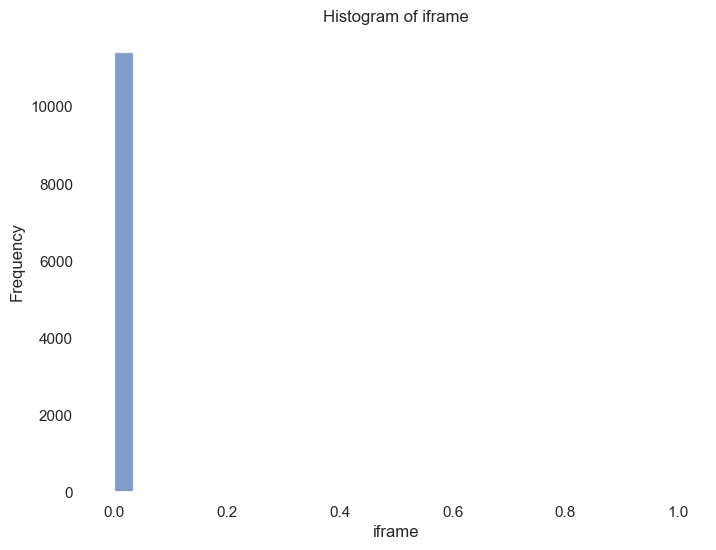

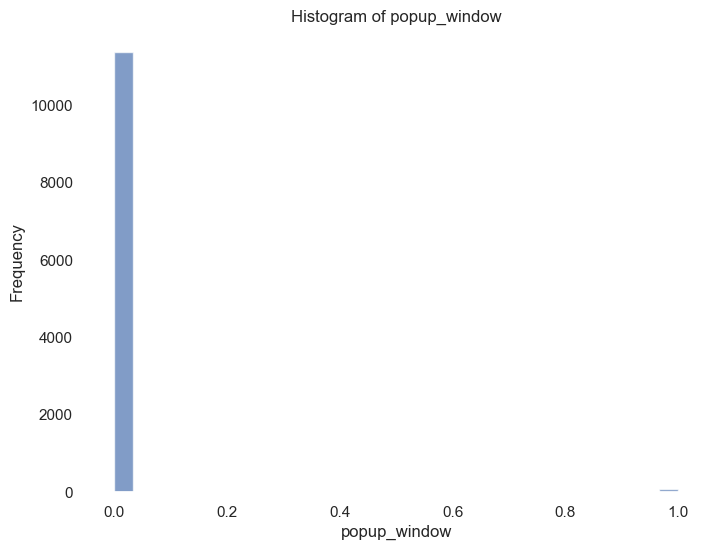

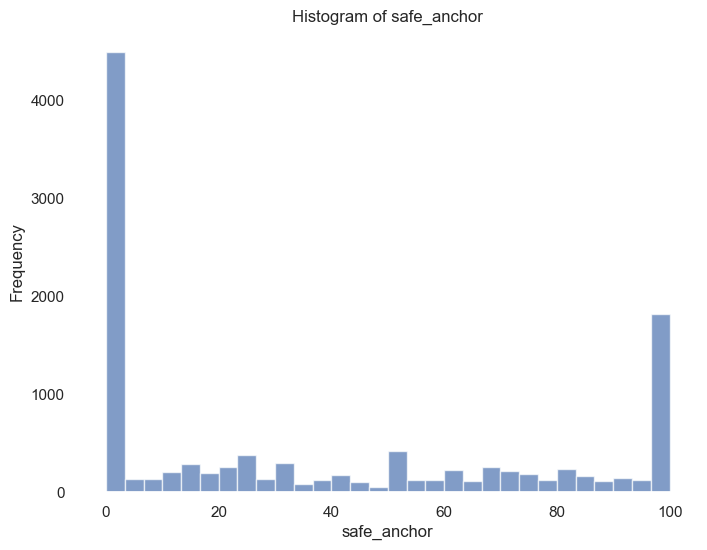

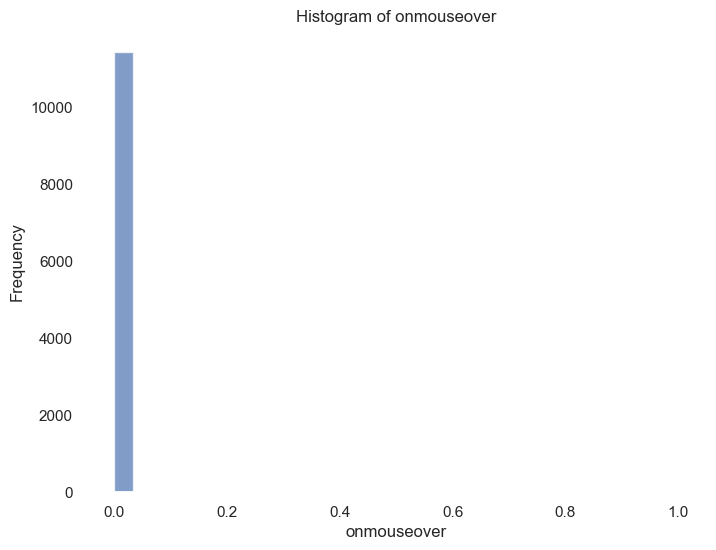

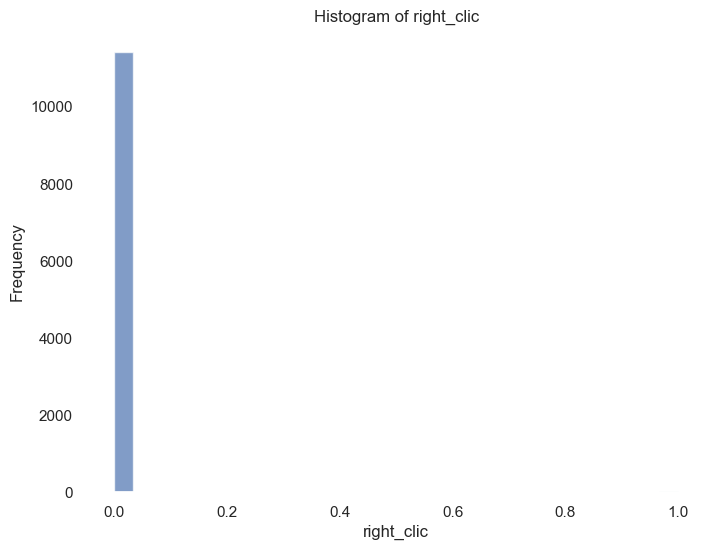

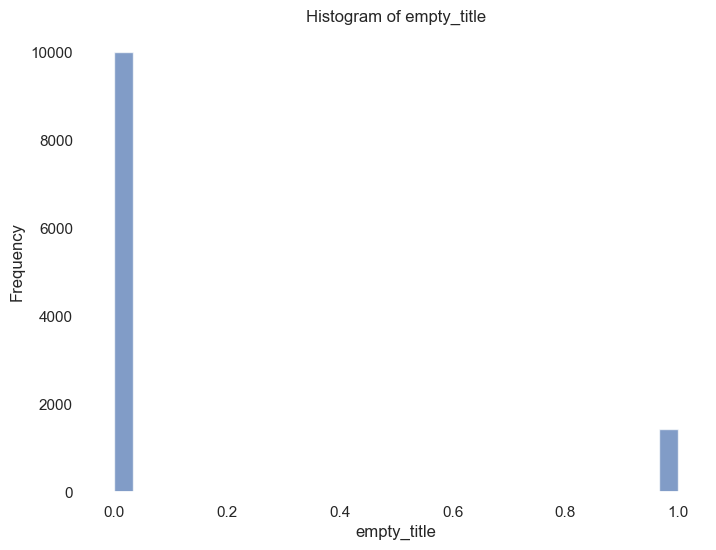

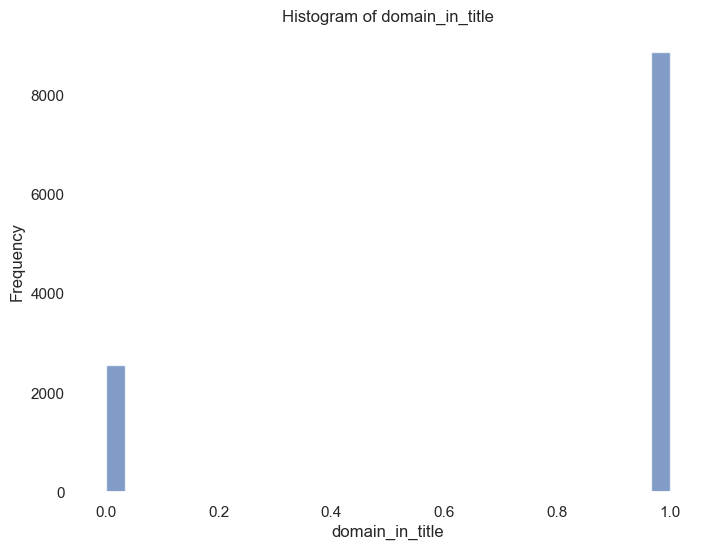

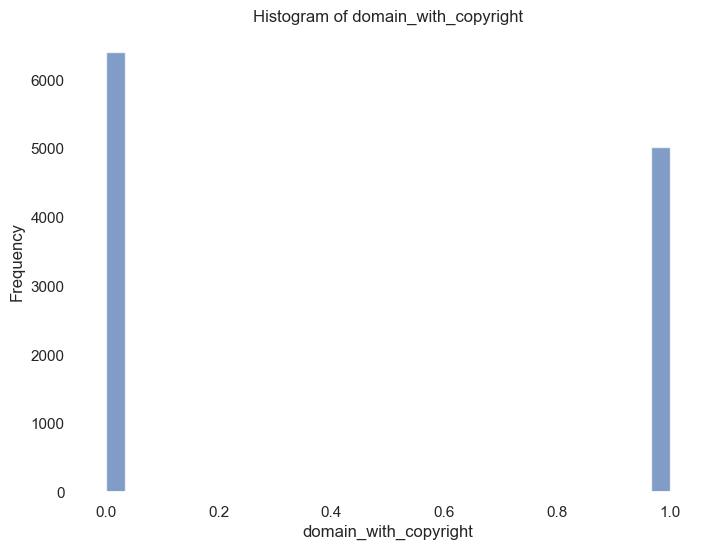

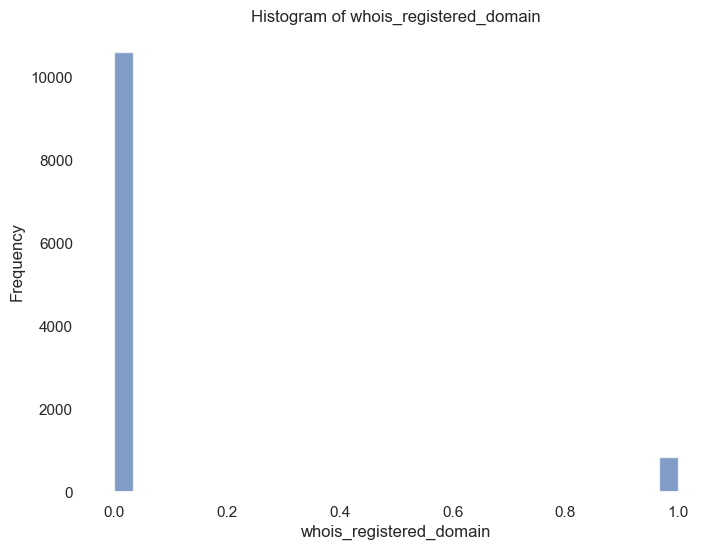

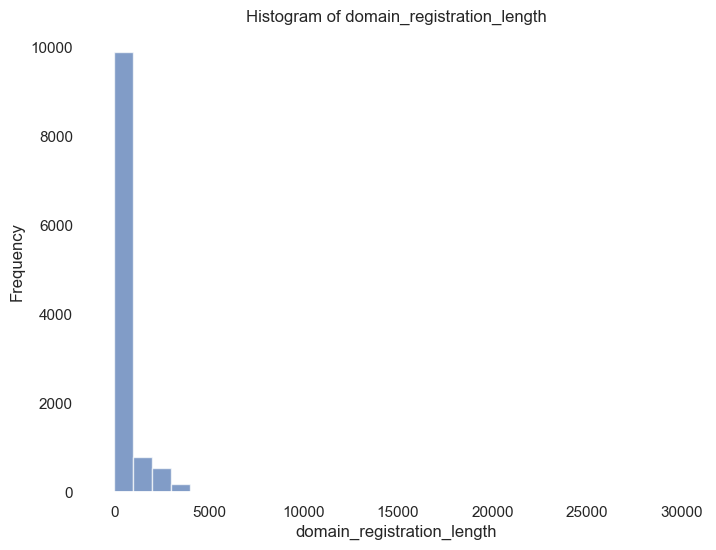

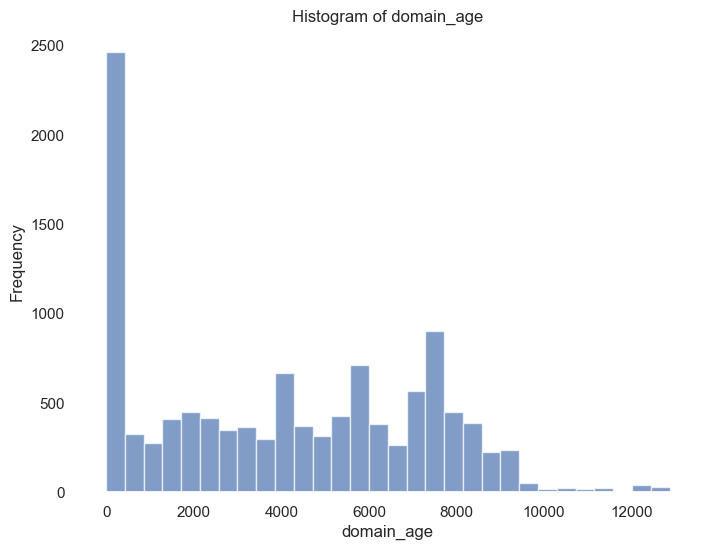

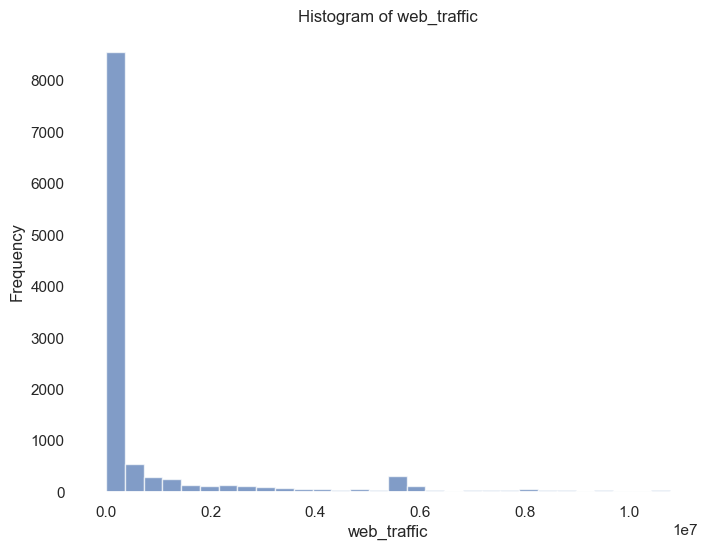

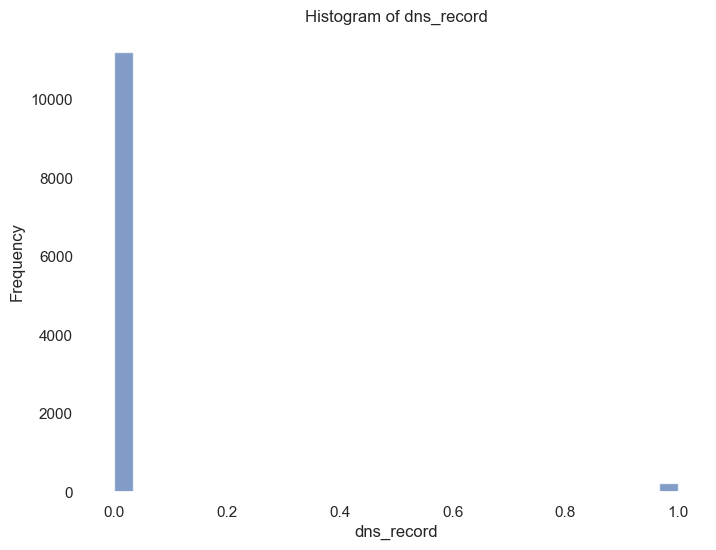

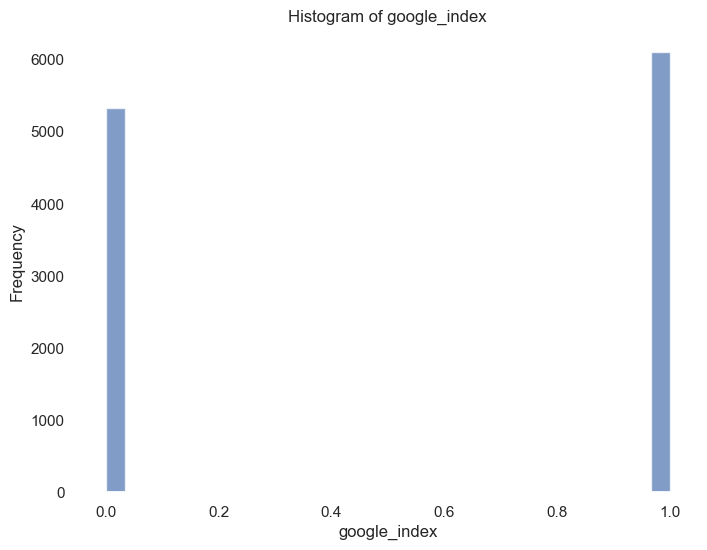

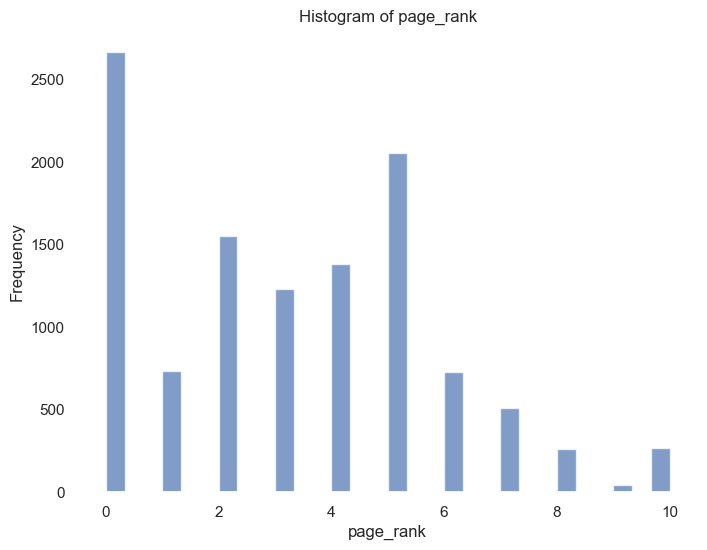

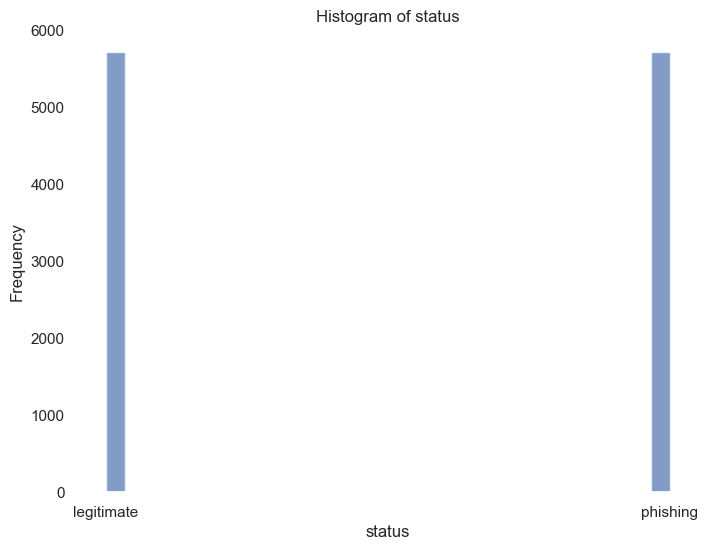

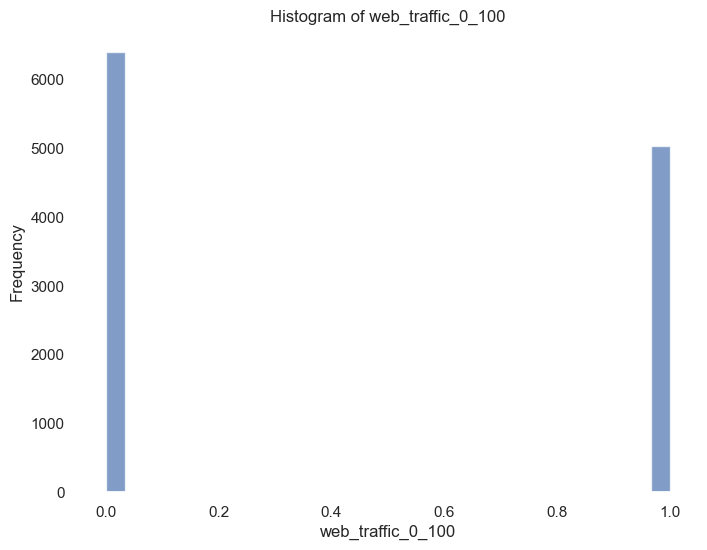

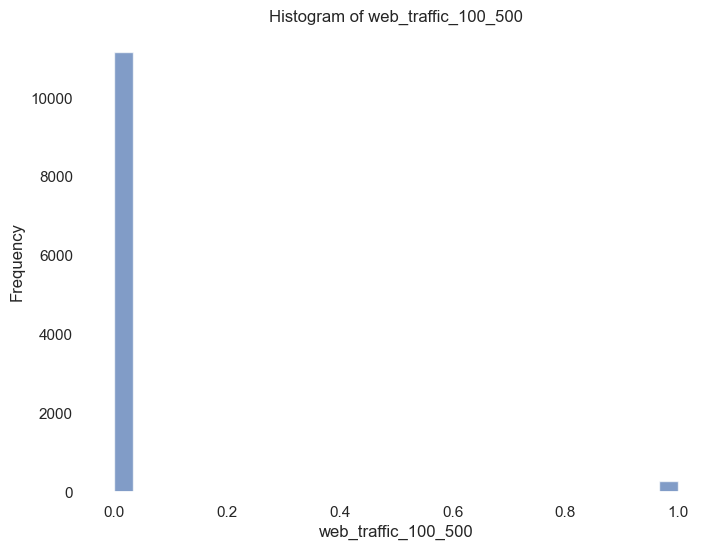

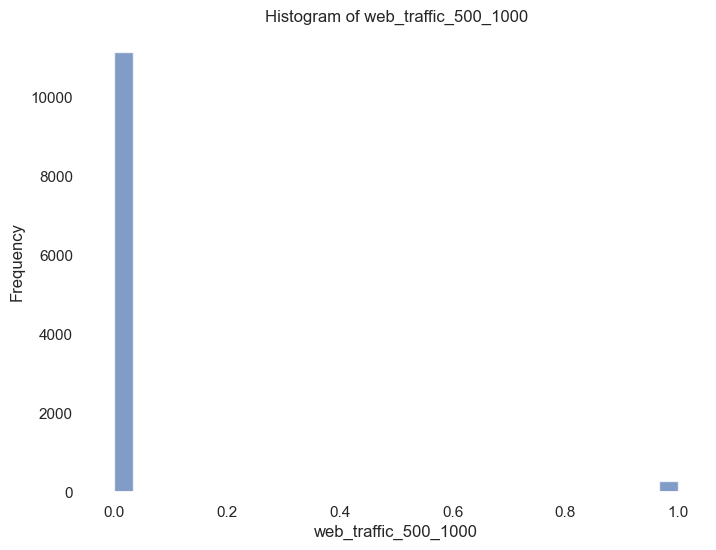

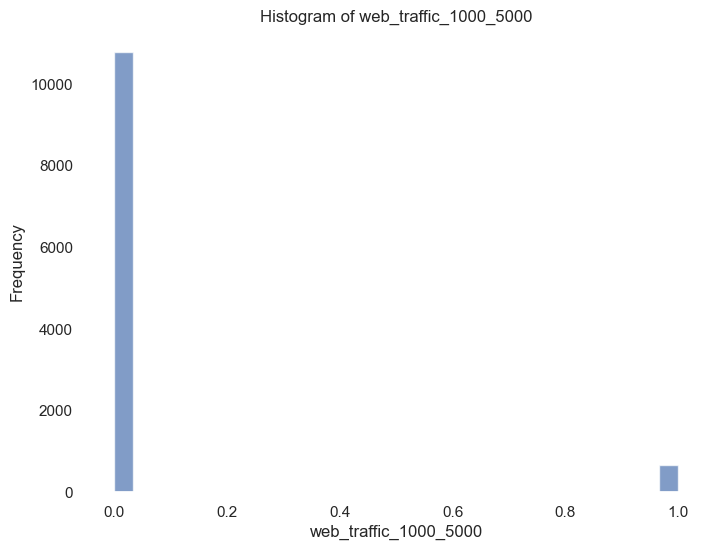

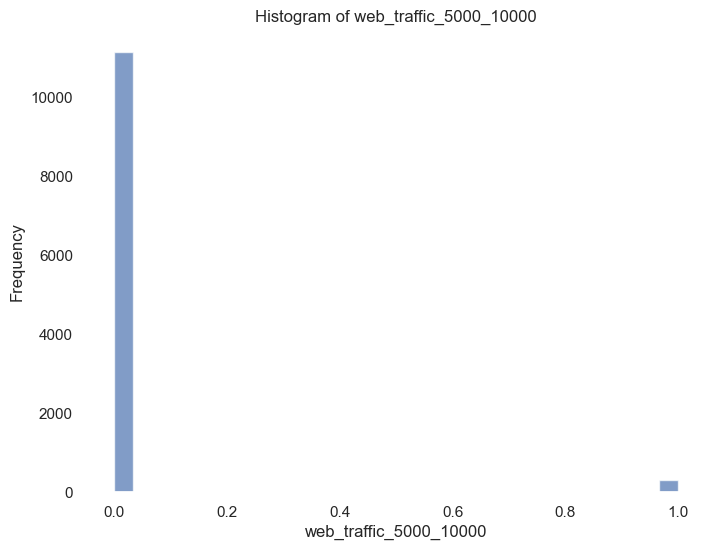

In [49]:
# Converting the PySpark DataFrame to a Pandas DataFrame
data_pd = data.toPandas()

# Iterate through columns and generate histograms
for column_name in data_pd.columns:
    plt.figure(figsize=(8, 6))
    plt.hist(data_pd[column_name], bins=30, alpha=0.7)
    plt.xlabel(column_name)
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {column_name}")
    plt.show()


## Takeaway from EDA

- Here are 11430 rows with 89 columns taking 6.03 Mb of storage
- There seems to be no duplicate data and data is well balanced with 5715 instances
- www.eaglecountry.us is the url with longest domain registration among 11430 data.
- Among a dataset of 11,430 entries, the website 'www.eaglecountry.us' stands out with the longest domain registration, while 'www.abm.edu.ar' has the shortest domain registration
- The website 'www.knowledgeonecorp.com' has recorded the highest traffic at 10,767,986 visits, followed closely by 'www.margarita.md' with 10,749,999 visits, and 'www.chel.media' with 10,745,722 visits
- Among a dataset of 11,430 entries, 8,868 urls contains their own domain names within their URLs.
- Pageranks seems to have normal distribution
- The top three websites with the highest PageRank values (10) are sites.google.com/site/ilyasdxih, cloud.google, and google.com/forms
- The three three websites with the lowest PageRank values (0) are beta.kenaidanceta.com, batvrms.net and ktplasmachinery.com
- The dataset of 11,430 entries reveals that URLs have a range of lengths, from a minimum of 12 characters to a maximum of 1,641 characters. On average, the URLs are approximately 61 characters long.
- Instances with web traffic between 0 to 100 show more phishing cases (1235) compared to legitimate cases. But, instances with web traffic above 100 have more legitimate cases, suggesting a stronger legitimate presence in that range.
- Highly correlated features are longest_word_path with longest_word_raw and weekly correalated are length_url with nb_or
- Positivly Skewed-- length_url, nb_hyphenes,nb_slash, ratio_digits_url, legnth_words_raw,shortest_words_raw, shortest_word_path, longest_word_path, avg_words_raw, avg_word_host
- Bimodal distribution - ratio_intHyperlinks, links_in_tags,safe_anchor
- Multimodal distribution - domain_age, pagerank

> For model classification look  for **Pyspark ML for web page fraudulent domain detection** 